Going to train on 50,000,000 molecules from GDB-17

May later try scraping for all molecules w/ positive charge

In [2]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline

import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam
import salty
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from random import shuffle
import pandas as pd

In [3]:
df = pd.read_csv('../../../../../../../GDB17.50000000', names=['smiles'])

only N+ contain positive charges in this dataset

In [3]:
df = df[df['smiles'].str.contains("N+", regex=False)]

In [4]:
values = df['smiles']
print(values.shape)

(50000000,)


In [5]:
smile_max_length = values.map(len).max()
print(smile_max_length)

51


We may want to remove cations with more than 25 heavy atoms

(array([1.0000000e+00, 6.0000000e+00, 6.3700000e+02, 1.4796200e+05,
        6.6722430e+06, 2.9969172e+07, 1.2690346e+07, 5.0860600e+05,
        1.0870000e+04, 1.5700000e+02]),
 array([ 2. ,  6.9, 11.8, 16.7, 21.6, 26.5, 31.4, 36.3, 41.2, 46.1, 51. ]),
 <a list of 10 Patch objects>)

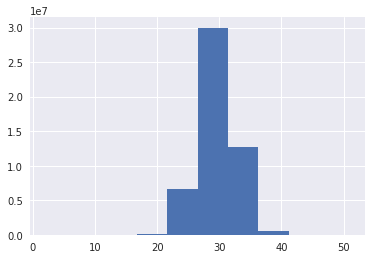

In [6]:
plt.hist(values.map(len))

In [7]:
def pad_smiles(smiles_string, smile_max_length):
     if len(smiles_string) < smile_max_length:
            return smiles_string + " " * (smile_max_length - len(smiles_string))

In [8]:
padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]

In [9]:
shuffle(padded_smiles)

In [10]:
def create_char_list(char_set, smile_series):
    for smile in smile_series:
        char_set.update(set(smile))
    return char_set

In [11]:
char_set = set()
char_set = create_char_list(char_set, padded_smiles)

In [12]:
print(len(char_set))
char_set

31


{' ',
 '#',
 '(',
 ')',
 '+',
 '-',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '=',
 'B',
 'C',
 'F',
 'H',
 'I',
 'N',
 'O',
 'S',
 '[',
 ']',
 'c',
 'l',
 'n',
 'o',
 'r',
 's'}

In [13]:
properties = ['density', 'cpt', 'viscosity', 'thermal_conductivity',
              'melting_point']
props = properties
devmodel = salty.aggregate_data(props, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation']
cations = devmodel.Data['smiles_string'].drop_duplicates()
cations = cations.reset_index(drop=True)
print(cations.shape)

(276,)


In [14]:
padded_smiles_2 =  [pad_smiles(i, smile_max_length) for i in cations if pad_smiles(i, smile_max_length)]

In [15]:
char_set_2 = set()
char_set_2 = create_char_list(char_set_2, padded_smiles_2)

In [16]:
char_set.update(set(char_set_2))

In [17]:
char_set

{' ',
 '#',
 '(',
 ')',
 '+',
 '-',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '=',
 'B',
 'C',
 'F',
 'H',
 'I',
 'N',
 'O',
 'P',
 'S',
 '[',
 '\\',
 ']',
 'c',
 'l',
 'n',
 'o',
 'r',
 's'}

In [18]:
char_list = list(char_set)
chars_in_dict = len(char_list)
char_to_index = dict((c, i) for i, c in enumerate(char_list))
index_to_char = dict((i, c) for i, c in enumerate(char_list))

In [328]:
import json
json = json.dumps(char_to_index)
f = open("1mil_GDB17.json","w")
f.write(json)
f.close()

In [19]:
# if loading previous model
smile_max_length = 51
import json
f = open("1mil_GDB17.json","r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
index_to_char = dict((i, c) for i, c in enumerate(char_list))
chars_in_dict = len(char_list)

In [20]:
set(char_to_index.keys())

{' ',
 '#',
 '(',
 ')',
 '+',
 '-',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '=',
 'B',
 'C',
 'F',
 'H',
 'I',
 'N',
 'O',
 'P',
 'S',
 '[',
 '\\',
 ']',
 'c',
 'l',
 'n',
 'o',
 'r',
 's'}

In [39]:
data_size = 1000000

In [28]:
X_train = np.zeros((data_size, smile_max_length, chars_in_dict), dtype=np.float32)

In [29]:
X_train.shape

(1000000, 51, 33)

In [30]:
import random

In [31]:
random.choice(cations)

'[P+](CC)(CC)(CC)CCCCCCC'

In [32]:
# for each i, randomly select whether to sample from GDB or cations (padded_smiles_2)
for i, smile in enumerate(padded_smiles[:data_size]):
#     linearly_scaled_prob = random.random() < i/data_size
#     if linearly_scaled_prob:
    smile = random.choice(cations)
    for j, char in enumerate(smile):
        X_train[i, j, char_to_index[char]] = 1

In [340]:
for i, smile in enumerate(padded_smiles[:data_size]):
    for j, char in enumerate(smile):
        X_train[i, j, char_to_index[char]] = 1

In [33]:
X_train, X_test = train_test_split(X_train, test_size=0.33, random_state=42)

In [34]:
X_train[0]

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [35]:
X_train.shape

(670000, 51, 33)

In [36]:
# build special X_train that contains 50% bootstrapped cation data

In [37]:
# need to build RNN to encode. some issues include what the 'embedded dimension' is (vector length of embedded sequence)

so some keras version stuff. 1.0 uses keras.losses to store its loss functions. 2.0 uses objectives. we'll just have to be consistent

In [38]:
from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

Here I've adapted the exact architecture used in the [paper](https://github.com/maxhodak/keras-molecules/blob/master/molecules/model.py)

In [40]:
def Encoder(x, latent_rep_size, smile_max_length, epsilon_std = 0.01):
    h = Convolution1D(9, 9, activation = 'relu', name='conv_1')(x)
    h = Convolution1D(9, 9, activation = 'relu', name='conv_2')(h)
    h = Convolution1D(10, 11, activation = 'relu', name='conv_3')(h)
    h = Flatten(name = 'flatten_1')(h)
    h = Dense(435, activation = 'relu', name = 'dense_1')(h)

    def sampling(args):
        z_mean_, z_log_var_ = args
        batch_size = K.shape(z_mean_)[0]
        epsilon = K.random_normal(shape=(batch_size, latent_rep_size),
                                  mean=0., stddev = epsilon_std)
        return z_mean_ + K.exp(z_log_var_ / 2) * epsilon

    z_mean = Dense(latent_rep_size, name='z_mean', activation = 'linear')(h)
    z_log_var = Dense(latent_rep_size, name='z_log_var', activation = 'linear')(h)

    def vae_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = smile_max_length * binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - \
                                 K.exp(z_log_var), axis = -1)
        return xent_loss + kl_loss

    return (vae_loss, Lambda(sampling, output_shape=(latent_rep_size,),
                             name='lambda')([z_mean, z_log_var]))

def Decoder(z, latent_rep_size, smile_max_length, charset_length):
    h = Dense(latent_rep_size, name='latent_input', activation = 'relu')(z)
    h = RepeatVector(smile_max_length, name='repeat_vector')(h)
    h = GRU(501, return_sequences = True, name='gru_1')(h)
    h = GRU(501, return_sequences = True, name='gru_2')(h)
    h = GRU(501, return_sequences = True, name='gru_3')(h)
    return TimeDistributed(Dense(charset_length, activation='softmax'),
                           name='decoded_mean')(h)

In [41]:
x = Input(shape=(smile_max_length, len(char_set)))

In [42]:
_, z = Encoder(x, latent_rep_size=292, smile_max_length=smile_max_length)

In [43]:
encoder = Model(x, z)

encoded_input looks like a dummy layer here:

In [44]:
encoded_input = Input(shape=(292,))

In [45]:
decoder = Model(encoded_input, Decoder(encoded_input, latent_rep_size=292,
                                       smile_max_length=smile_max_length,
                 charset_length=len(char_set)))

create a separate autoencoder model that combines the encoder and decoder (I guess the former cells are for accessing those separate parts of the model)

In [46]:
x1 = Input(shape=(smile_max_length, len(char_set)), name='input_1')

In [47]:
vae_loss, z1 = Encoder(x1, latent_rep_size=292, smile_max_length=smile_max_length)

In [48]:
autoencoder = Model(x1, Decoder(z1, latent_rep_size=292,
                                       smile_max_length=smile_max_length,
                 charset_length=len(char_set)))

we compile and fit

In [49]:
autoencoder.compile(optimizer='Adam', loss=vae_loss, metrics =['accuracy'])

In [50]:
autoencoder.fit(X_train, X_train, shuffle = False, validation_data=(X_test, X_test))

Train on 670000 samples, validate on 330000 samples
Epoch 1/1
670000/670000 [==============================] - 11427s 17ms/step - loss: 1.0780 - acc: 0.4574 - val_loss: 0.9336 - val_acc: 0.4419


In [54]:
#trained on 1million GDB17 molecules
autoencoder.save("1Mil_GDB17.h5")

In [345]:
#trained on 1million GDB17 molecules, 50/50 split of 500K GDB17/cation molecules, 500K cation molecules
autoencoder.save("1Mil_GDB17_split_500k_cation_500k.h5")

In [51]:
#trained on 1million cation molecules
autoencoder.save("Bootstrap_1Mil_Cation_1.h5")

In [318]:
#trained on 250K cation molecules
autoencoder.save("Bootstrap_250k_Cation_1.h5")

In [319]:
autoencoder.load_weights("1Mil_GDB17_split_500k.h5")

In [52]:
def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
#     a = np.log(a) / temperature
#     a = np.exp(a) / np.sum(np.exp(a))
#     return np.argmax(np.random.multinomial(1, a, 1))
    # work around from https://github.com/llSourcell/How-to-Generate-Music-Demo/issues/4
    a = np.log(a) / temperature 
    dist = np.exp(a)/np.sum(np.exp(a)) 
    choices = range(len(a)) 
    return np.random.choice(choices, p=dist)

In [53]:
# smi = values[29]
smi = cations[0]
print(smi)

CCCC[n+]1ccc(cc1)C


In [54]:
test_smi = smi
test_smi = pad_smiles(test_smi, smile_max_length)
Z = np.zeros((1, smile_max_length, len(char_list)), dtype=np.bool)
for t, char in enumerate(test_smi):
    Z[0, t, char_to_index[char]] = 1

In [69]:
string = ""
for i in autoencoder.predict(Z):
    for j in i:
        index = sample(j, temperature=1)
        string += index_to_char[index]
print("\n callback guess: " + string)


 callback guess: CCCC[n+]1ccc(cc1)C FB =3s\5Ss\B+873][[rOS4No4774[\S


In [35]:
properties = ['density', 'cpt', 'viscosity', 'thermal_conductivity',
              'melting_point']
props = properties
devmodel = salty.aggregate_data(props, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation']
cations = devmodel.Data['smiles_string'].drop_duplicates()
print(cations.shape)

(276,)


In [36]:
cations = cations.reset_index(drop=True)

In [37]:
test_smi = cations[100]
test_smi = pad_smiles(test_smi, smile_max_length)
Z = np.zeros((1, smile_max_length, len(char_list)), dtype=np.bool)
for t, char in enumerate(test_smi):
    Z[0, t, char_to_index[char]] = 1
test_smi

'OCCCCCC([n+]1ccn(c1)C)                             '

In [38]:
string = ""
for i in autoencoder.predict(Z):
    for j in i:
        index = sample(j)
        string += index_to_char[index]
print("\n callback guess: " + string)


 callback guess: 2o21 226227422 22]44333333c#S41S\#SICCs+SSF1P(SS+SS


Alright. So now I'm going to loop through our 276 cations, sample 100x from the decoder based on these representations, and see how many sanitize with the RDKit

In [369]:
cation_samples = []
for smi_index, smi in enumerate(cations):
    smi = pad_smiles(smi, smile_max_length)
    Z = np.zeros((1, smile_max_length, len(char_list)), dtype=np.bool)
    for t, char in enumerate(smi):
        Z[0, t, char_to_index[char]] = 1
    string = ""
    for i in autoencoder.predict(Z):
        for j in i:
            index = sample(j, temperature=0.5)
            string += index_to_char[index]
    cation_samples.append(string)

In [370]:
print('sampled cations: {}'.format(len(cation_samples)))
print('unique samples: {}'.format(pd.DataFrame(cation_samples).drop_duplicates().shape[0]))

sampled cations: 276
unique samples: 276


In [371]:
cation_samples[:10]

['CCCC1C+]CcccccC))CN                                ',
 'CCCn(C([C+]CCCC)C                                  ',
 'CCCCn1cC[nC]Cc1CCO                                 ',
 'CCCC(=O)N+]1(CCCC     C                            ',
 'CCCOC[CHC]CCCCCC=CCC   C                           ',
 'C21CC=CC=C2[N+]13C(C)(C=C(N1CCCCC)C)               ',
 'C2=CC=CCCC2[C+]1=C(C)(C=C(N1CNCC=C))O              ',
 'C(1CCCCCCCCP+C(CCCCCC)NCCCCCC)  C C     C          ',
 'CCCCCCCCn1Cc[n+]Cc1)C                              ',
 'CCCCnCCO[C+]C(C)N                                  ']

In [372]:
from rdkit import Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import Draw

In [373]:
def get_sim(vae_cat):
    scores = []
    for exp_cat in cations:
        ms = [vae_cat, Chem.MolFromSmiles(exp_cat)]
        fps = [FingerprintMols.FingerprintMol(x) for x in ms]
        score = DataStructs.FingerprintSimilarity(fps[0], fps[1])
        scores.append(score)
    return max(scores), scores.index(max(scores))

[N+](CCC(CC)(C)(CCC))C                             
CC[N+](CC)(CC)CCCCCCCC                             
CC1cC[n+](c1)CCCCCCCC                              
CCCCCCC(=C)CC1CCCCOOOC1            N               
C1=C[N+](CCC#C)=CN1CCCCCC                          
Cc1cc([n+](C1c2ccccc2)C)C                          
CCCCCC[C+](CCCCCO)(CCCCCC)CCCCCCC                  
C#CCCC1cc[C+](c1)CCN                               
CCCCCCC[n+]1cc[C](c1)CC                            
CCCCCCC[n+]1cc(C)ccc1                              
CCCCCC[n+]1cccc(C#N)c1                             
C1=C[N+](CCCC)=NN1C                                
CCNC[P+](CCCC)(CCCC)CCCC                           
CC1cc[C+](C1C)CCCCC                                
CCCCCCCCCCC[n+]1ccC(c1)C                           
CCCCC2CCCCC2CC[N+](CC)(CC)CC                       
[P+](CC)(CC)CCCC(CCCCCC)                           
C[N+]1(CCCC1)CC(C)(C)                              
C[N+]1(CCCCC1)CCO                                  
[P+](CC)(CO)

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


CC[C+](CC)(CC)CCCC                                 
C1=C[N+](C)CC(N)C1CCCOC                            


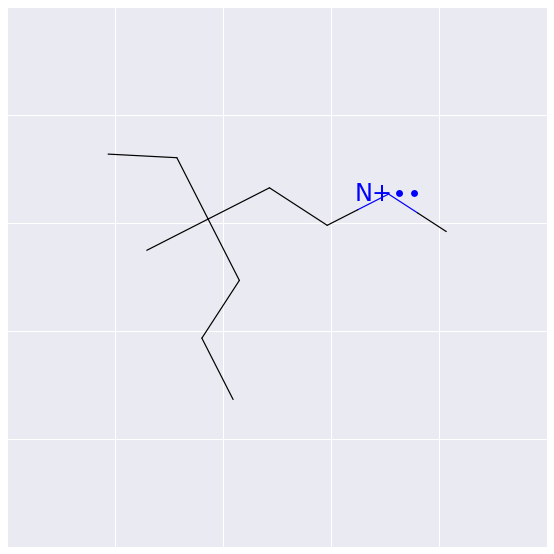

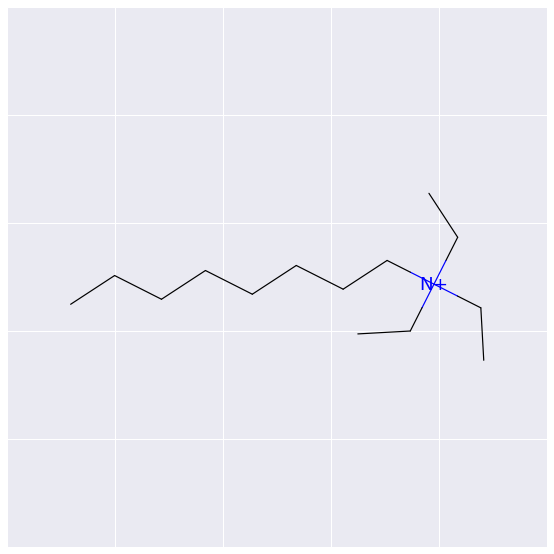

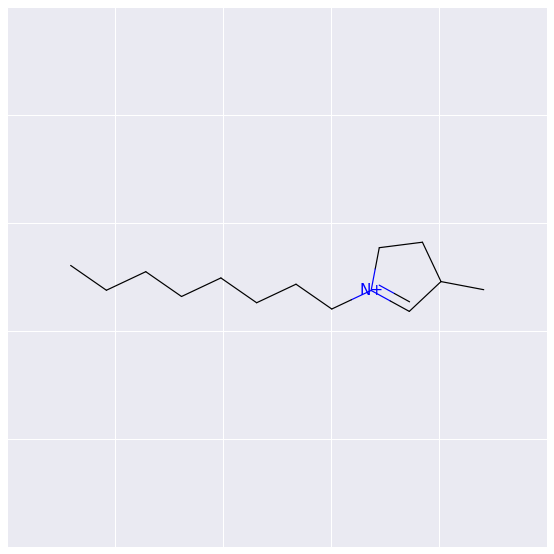

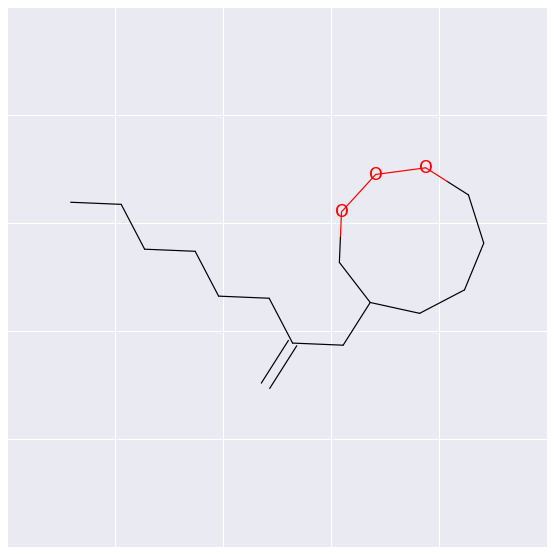

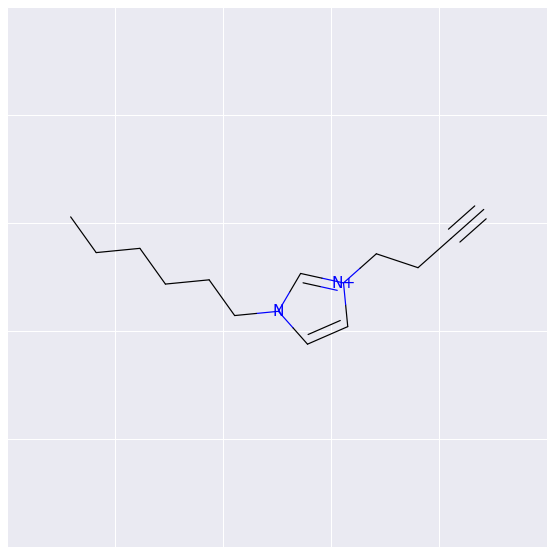

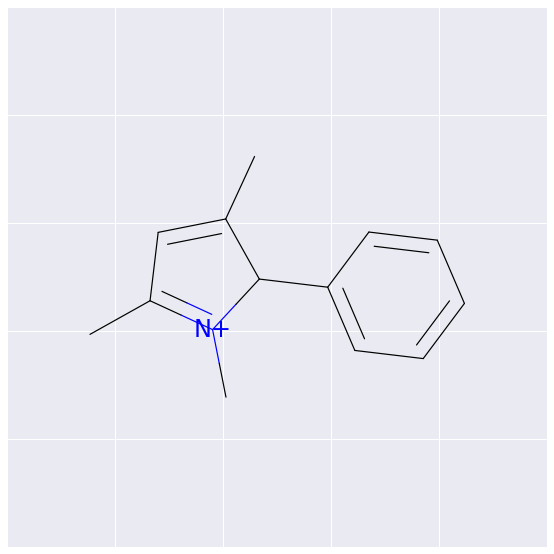

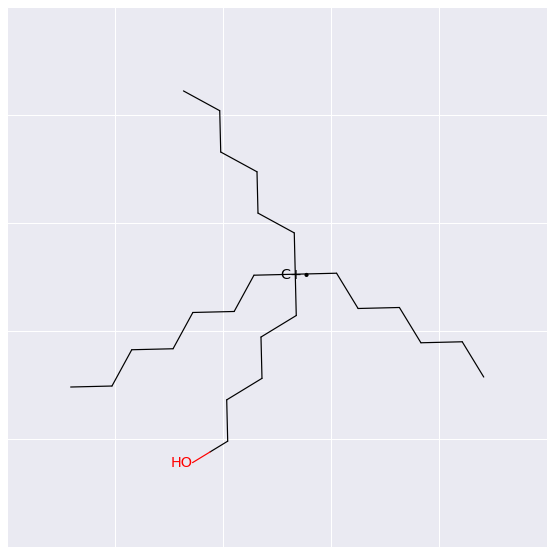

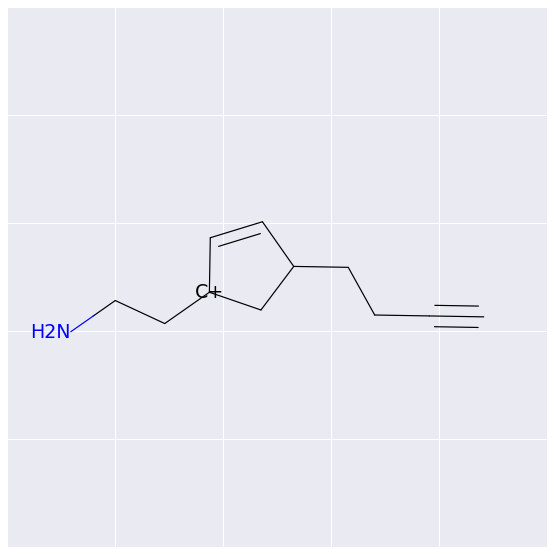

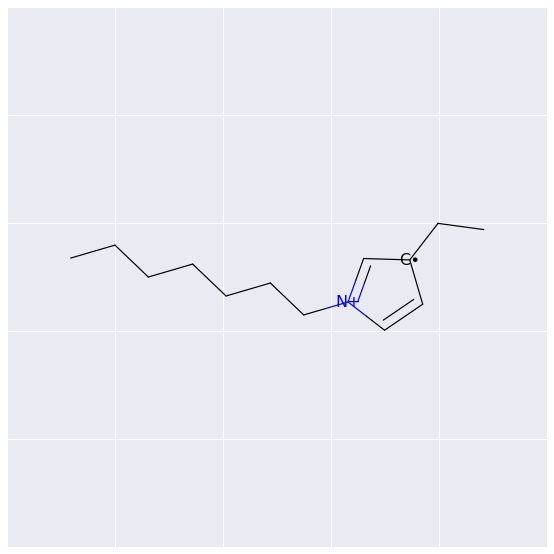

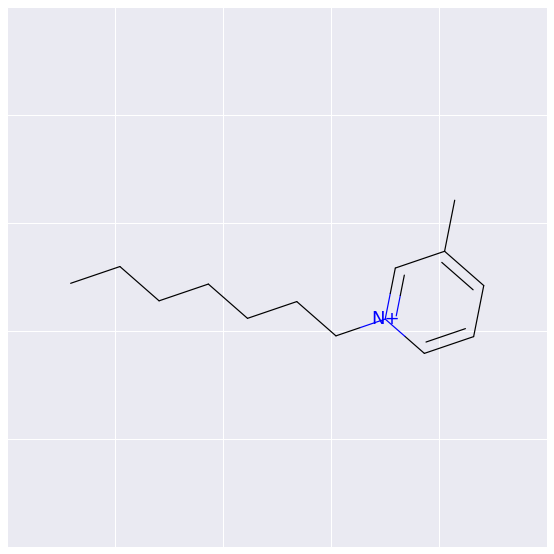

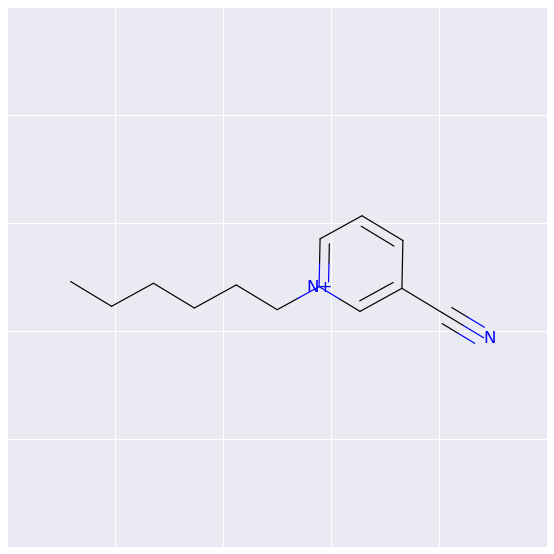

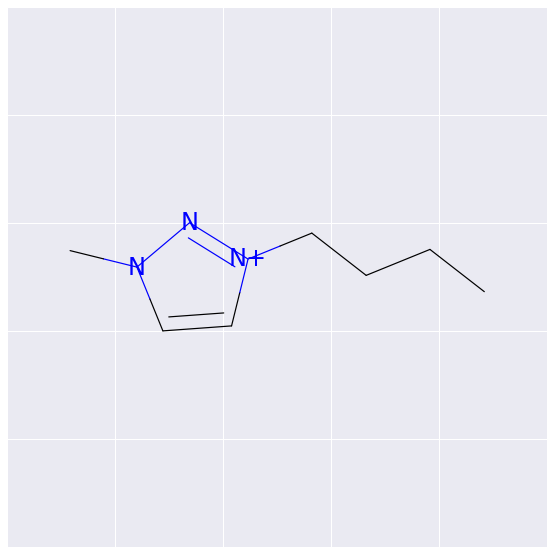

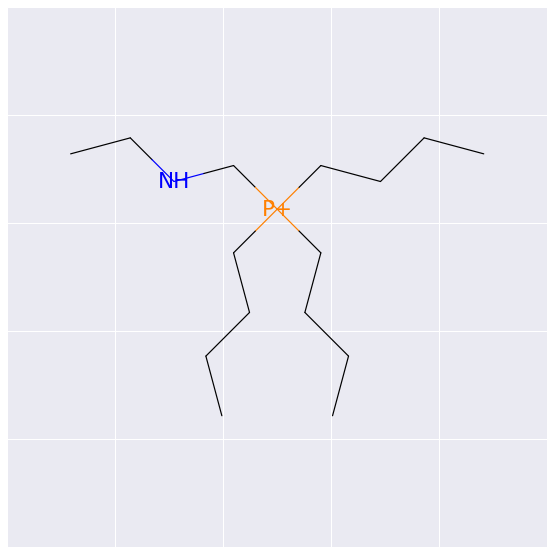

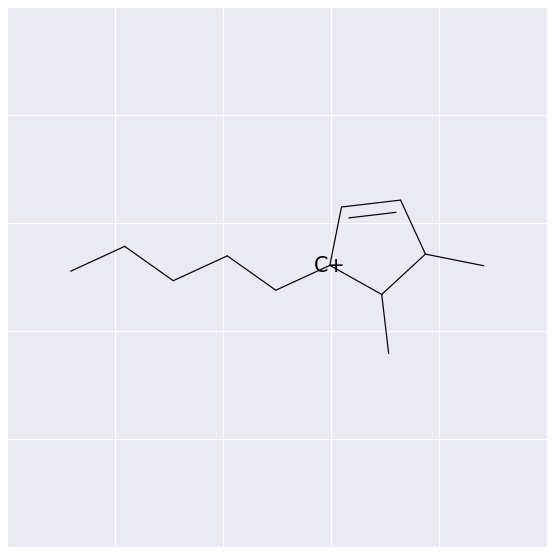

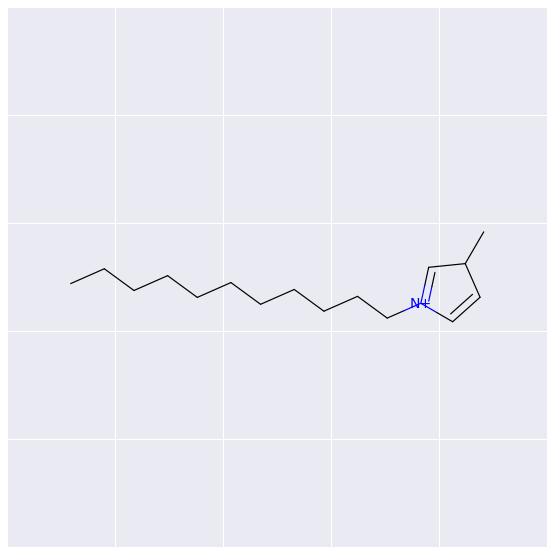

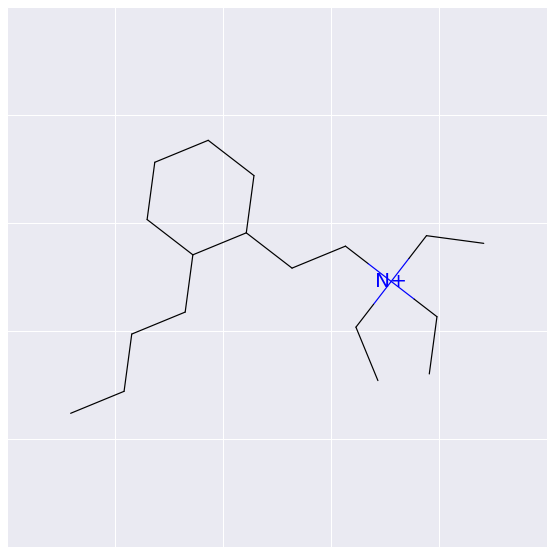

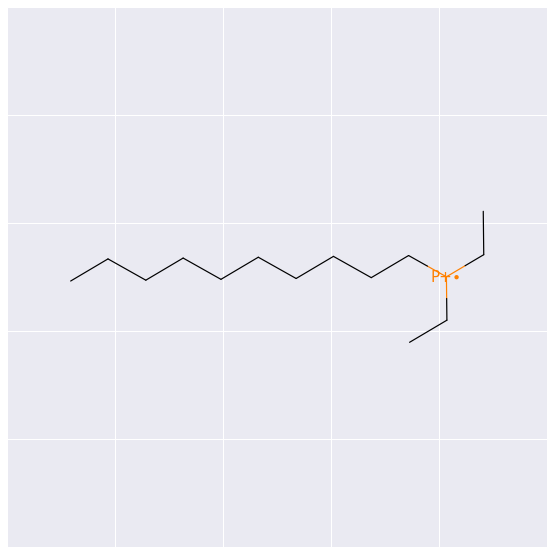

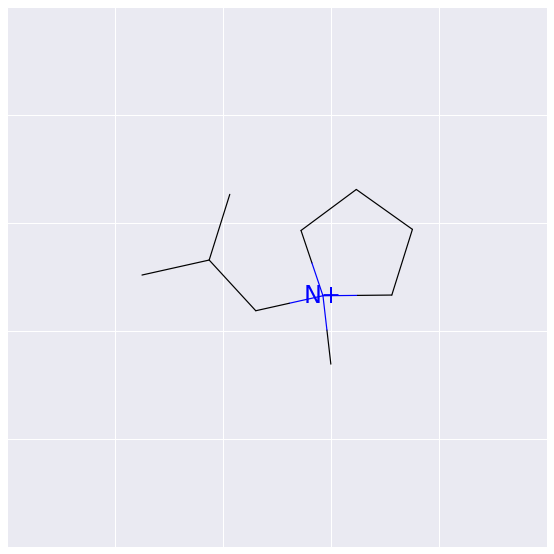

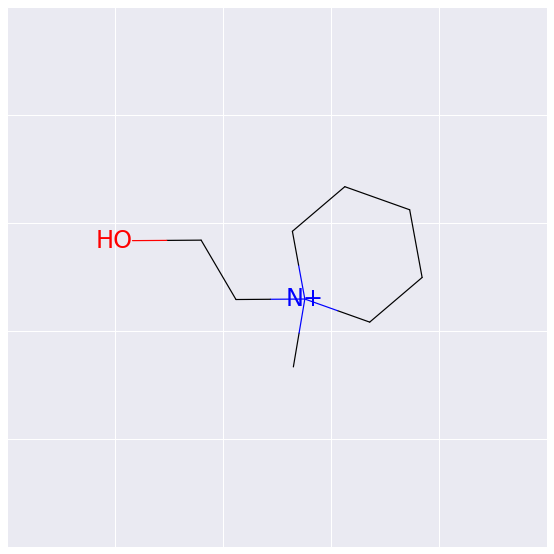

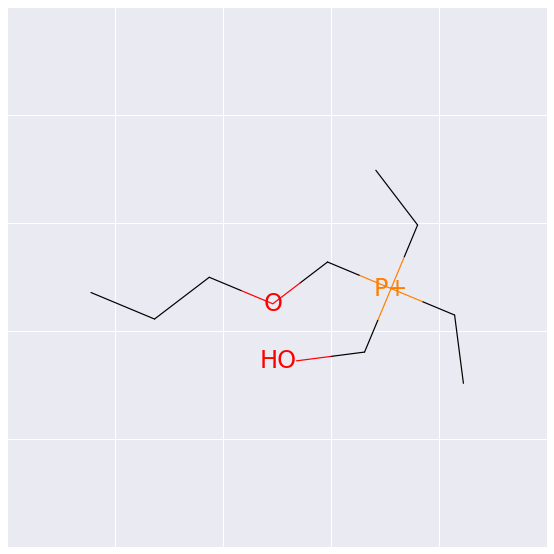

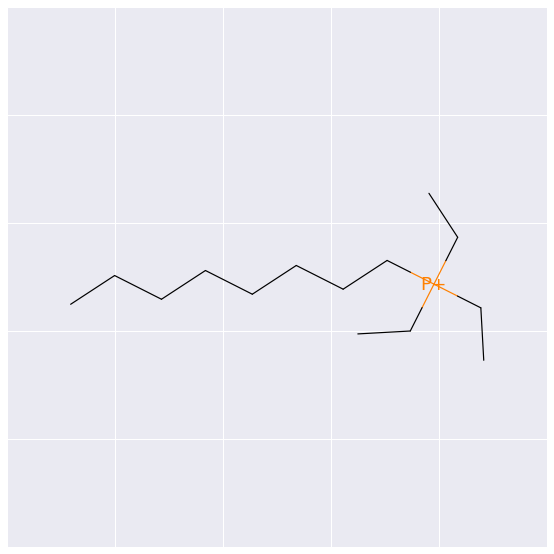

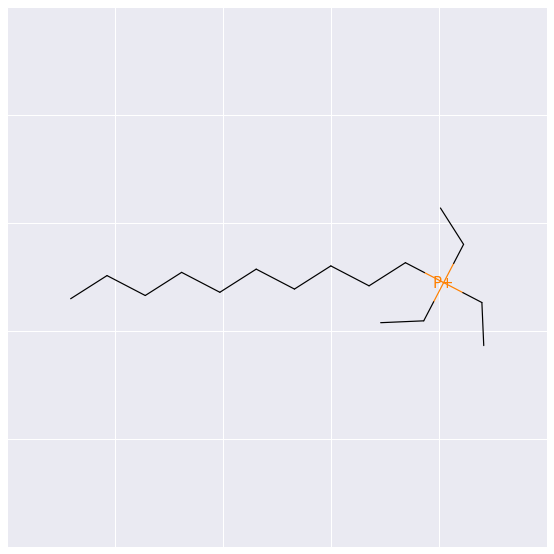

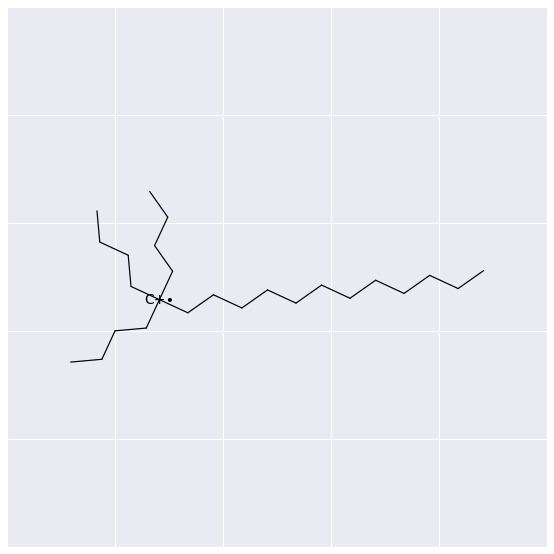

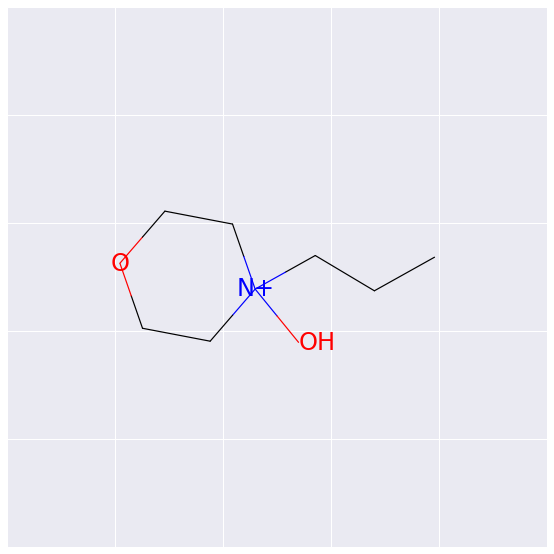

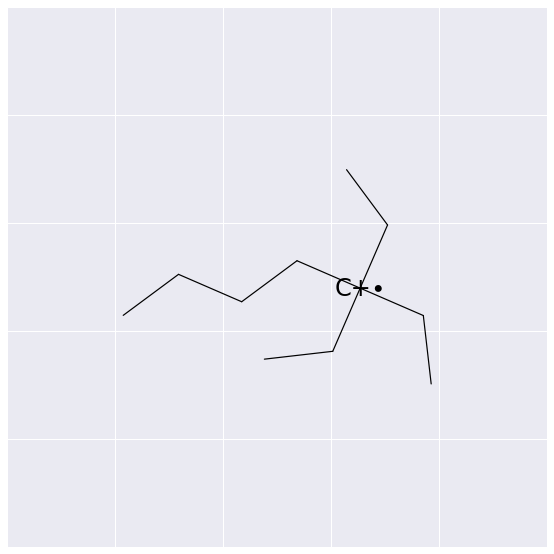

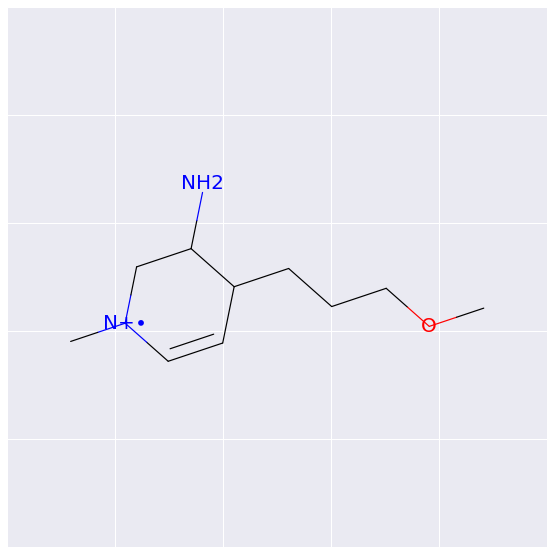

In [374]:
% matplotlib inline
rdkit_mols=[]
for smi in cation_samples:
    try:
        sampled = Chem.MolFromSmiles(smi)
        Draw.MolToMPL(sampled)
        rdkit_mols.append(smi)
        print(smi)
    except:
        pass

0.5434782608695652
1.0
0.5729166666666666
0.5
0.9090909090909091
0.532258064516129
0.46808510638297873
0.5166666666666667
0.5079365079365079
1.0


/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


1.0
0.5238095238095238
0.6666666666666666
0.5084745762711864
0.5161290322580645
0.7283950617283951
0.890625
1.0
0.872093023255814
0.8243243243243243
1.0
1.0
0.4222222222222222
0.6370967741935484
0.509090909090909
0.545


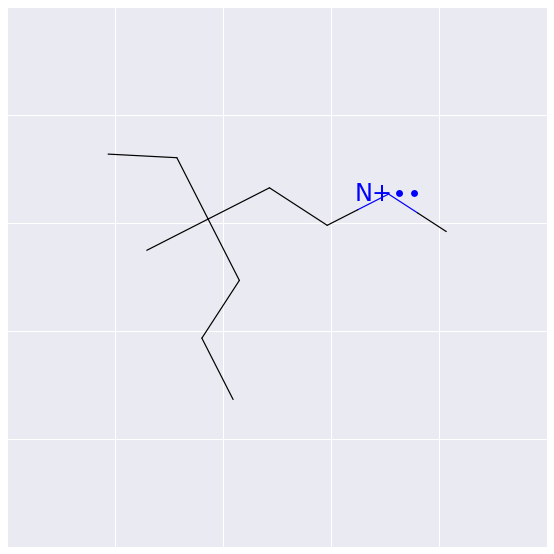

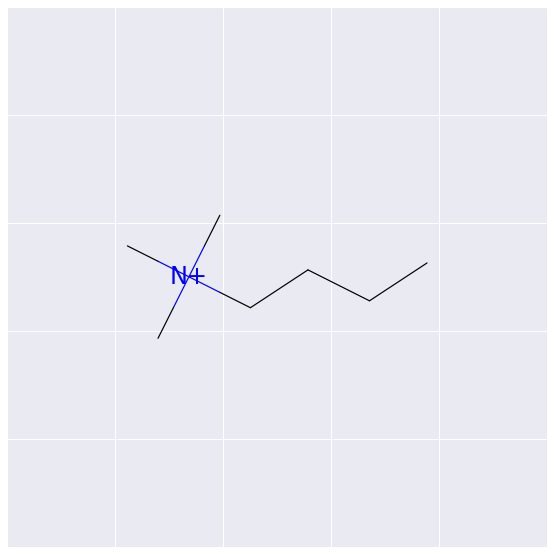

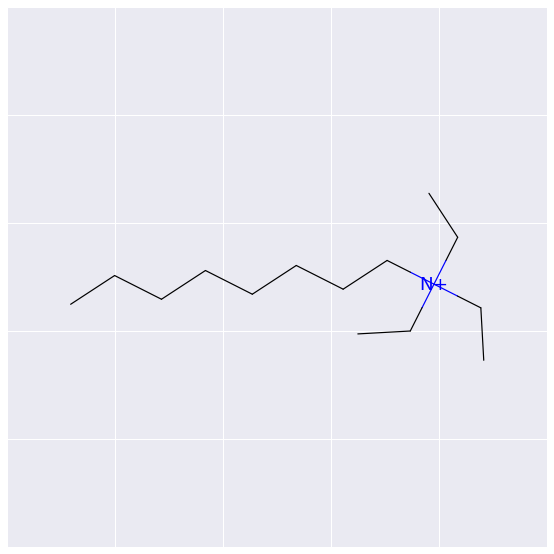

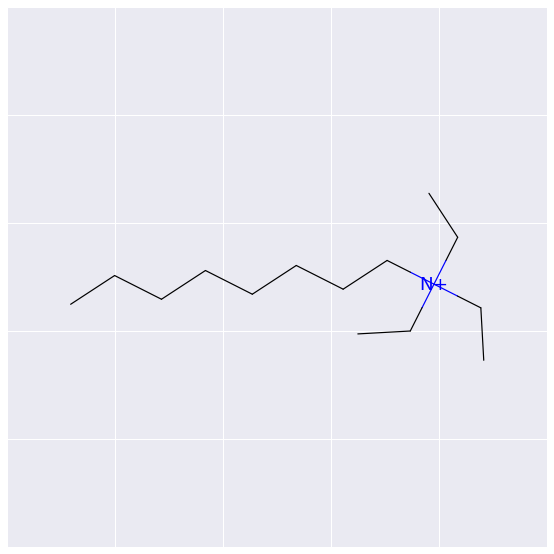

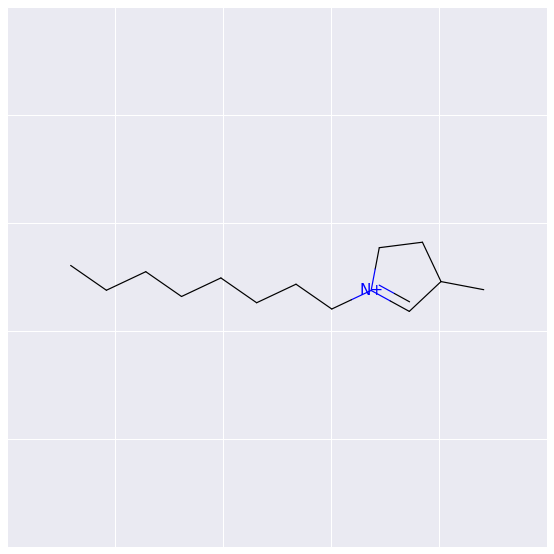

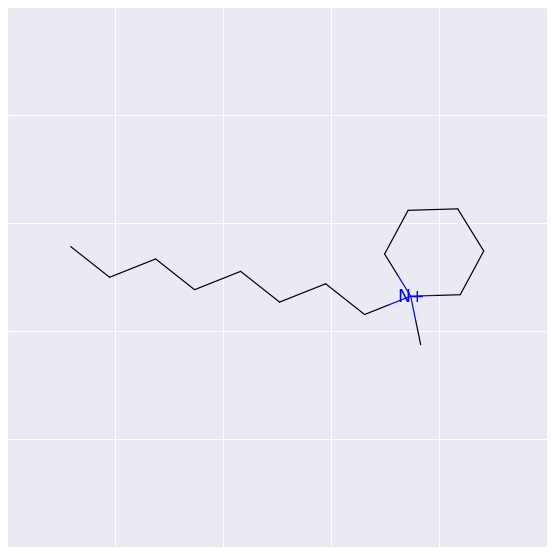

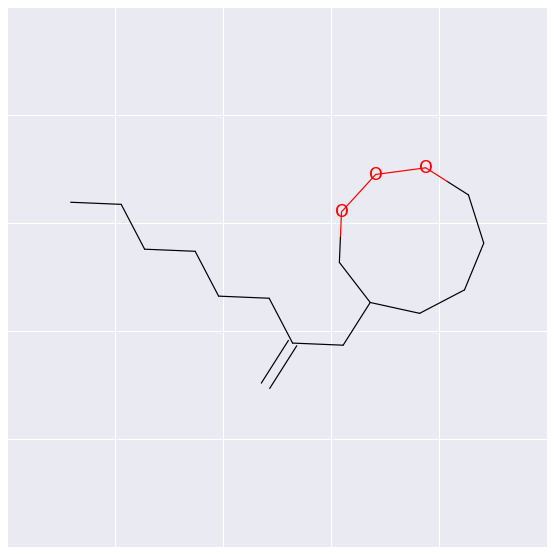

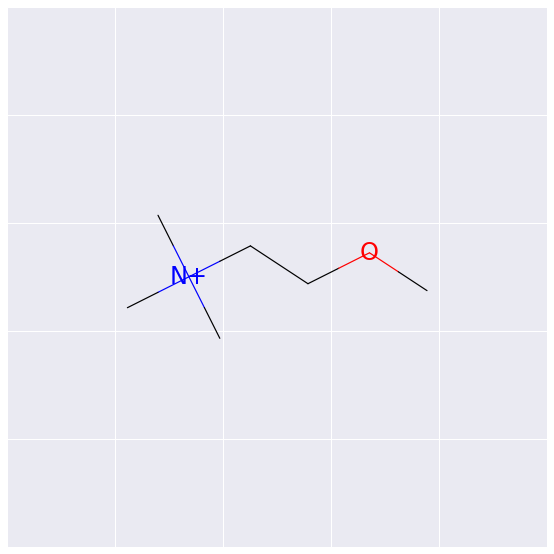

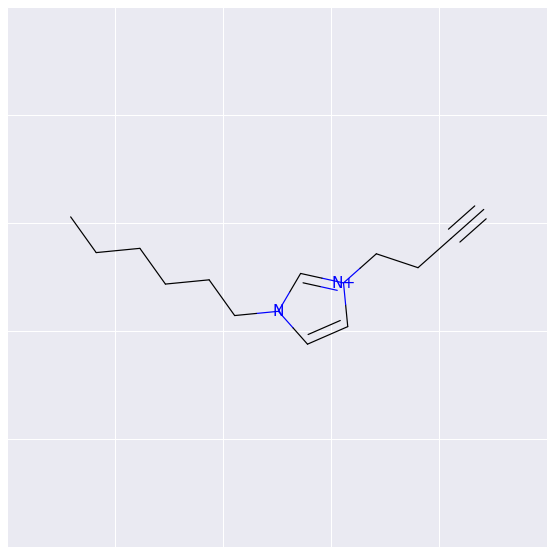

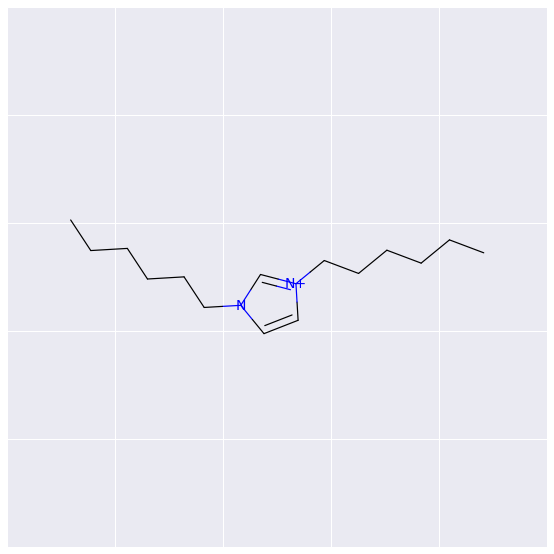

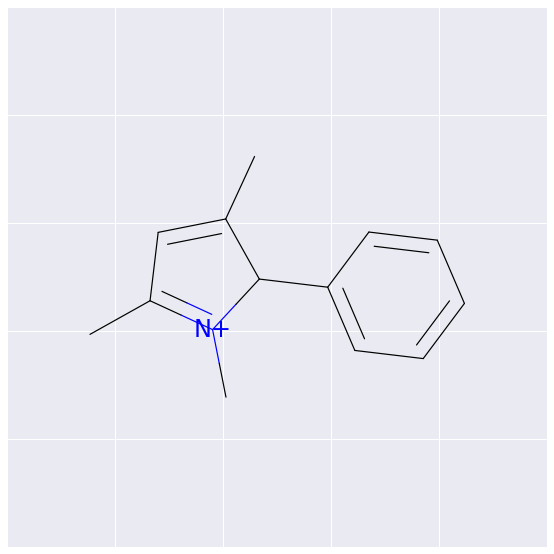

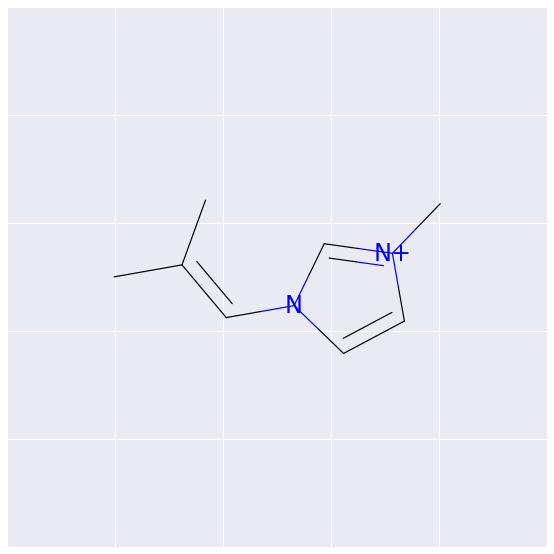

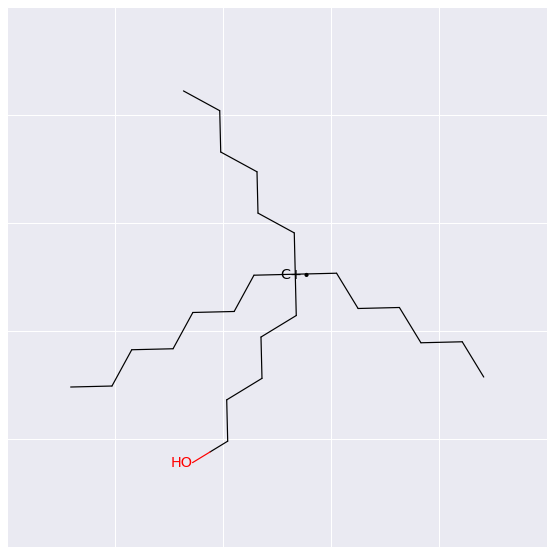

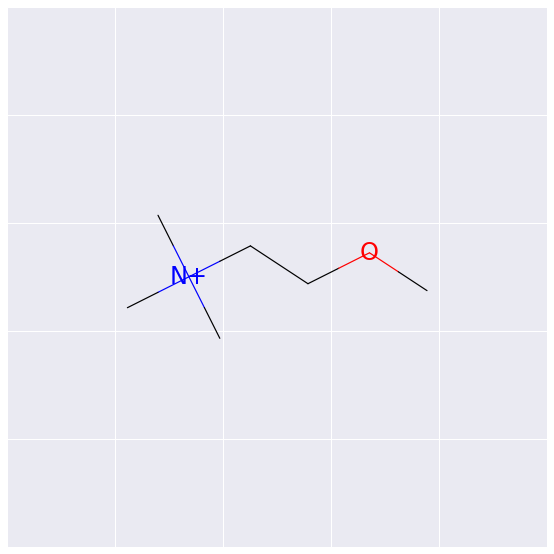

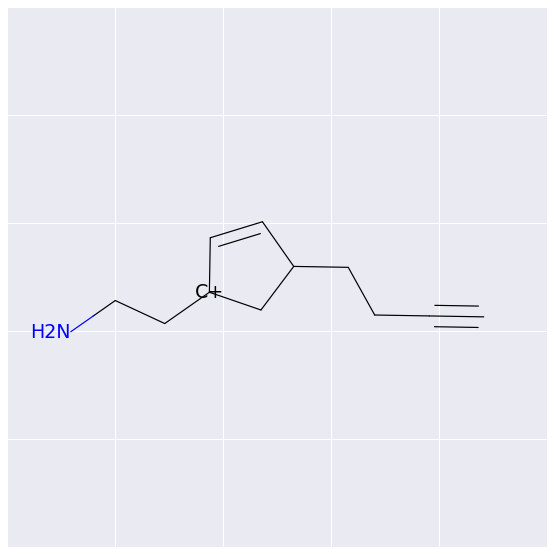

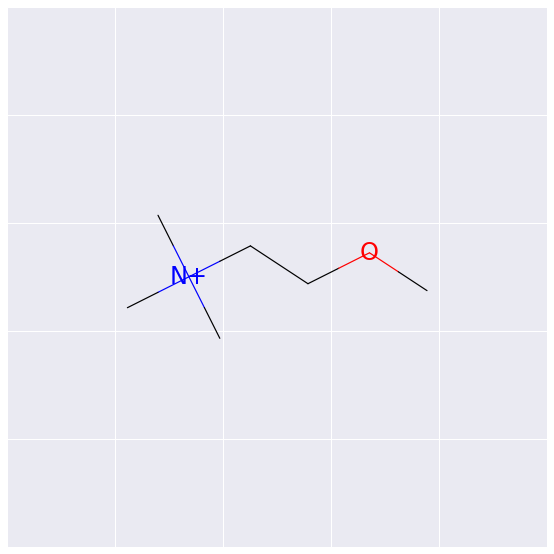

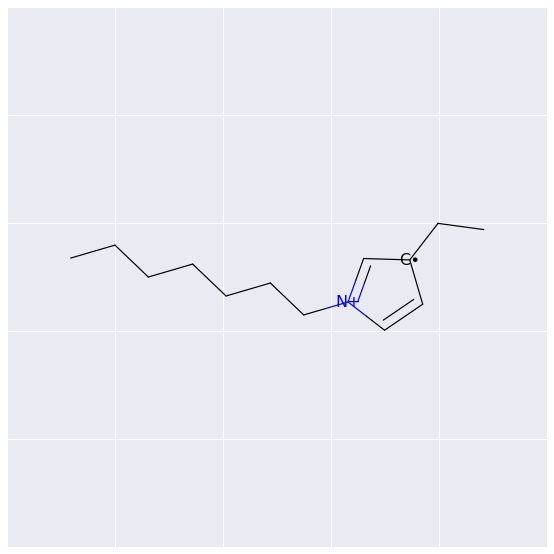

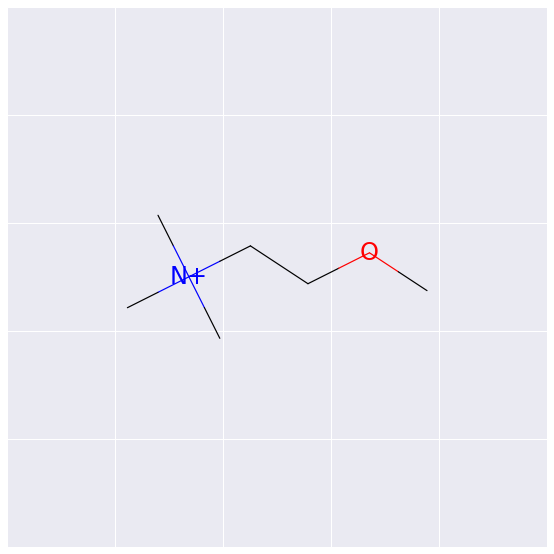

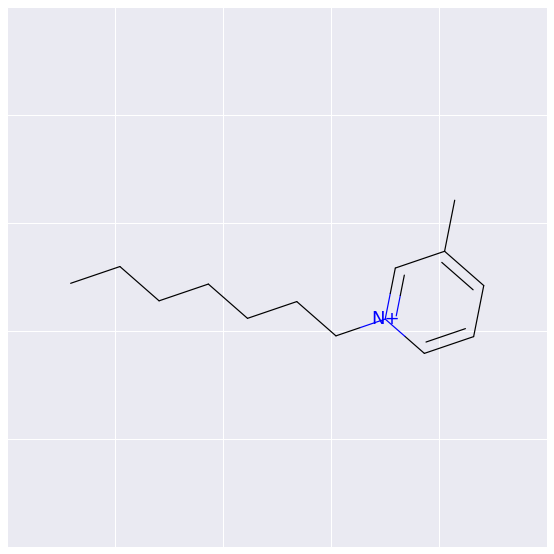

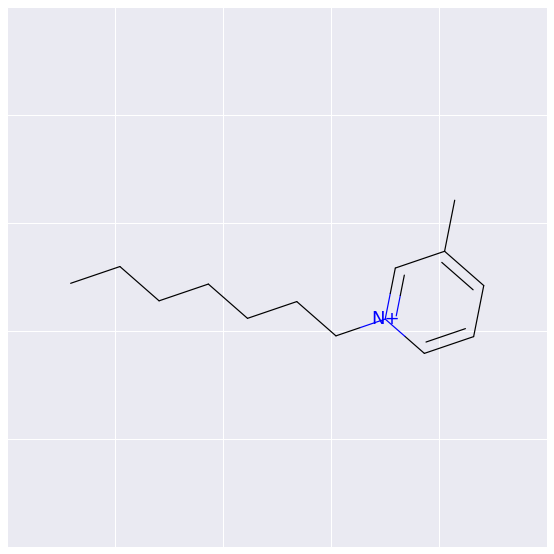

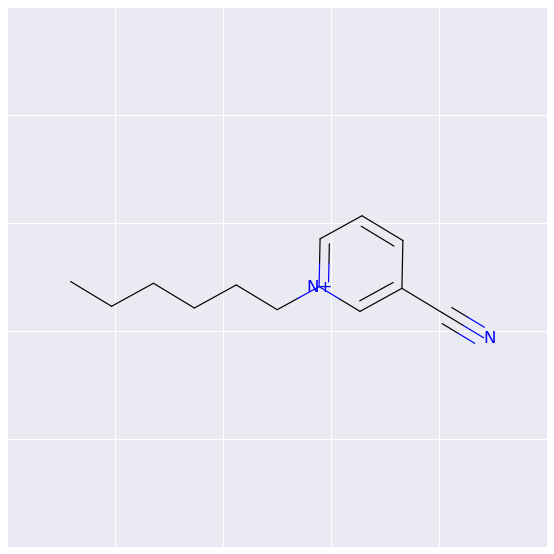

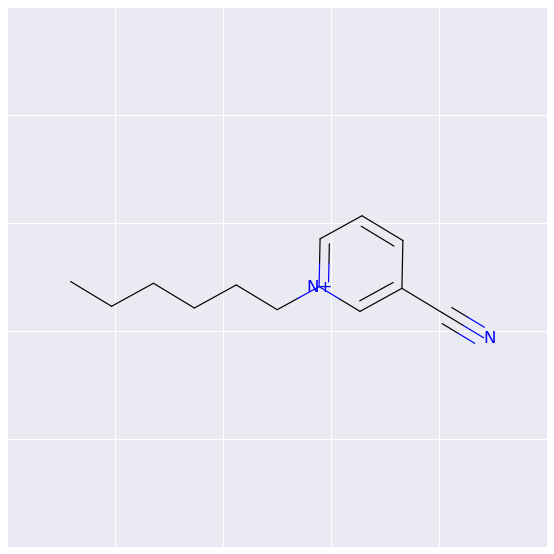

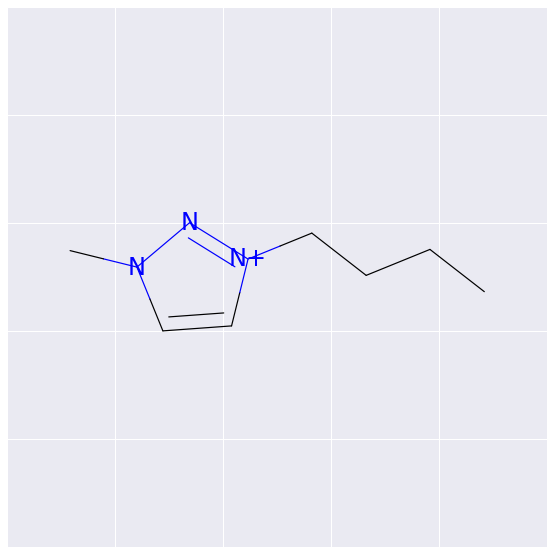

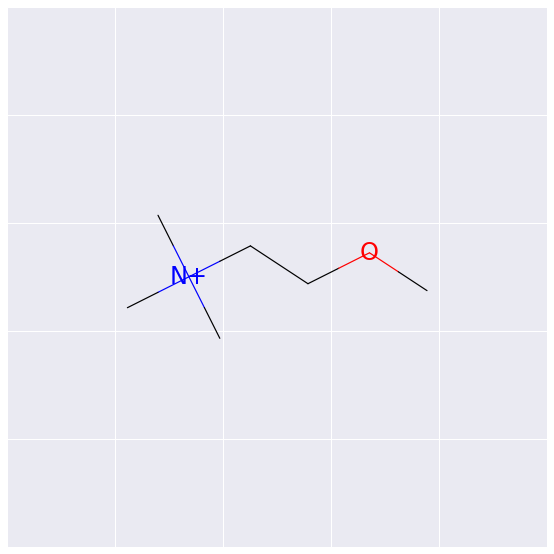

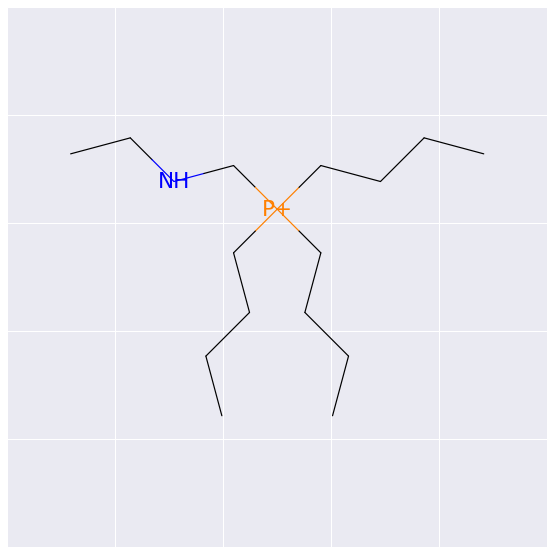

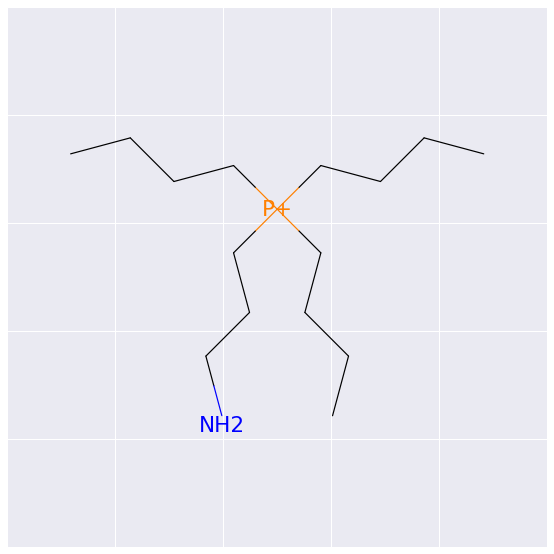

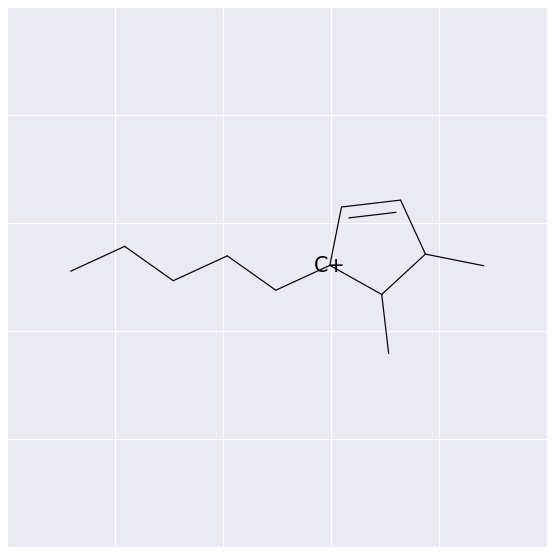

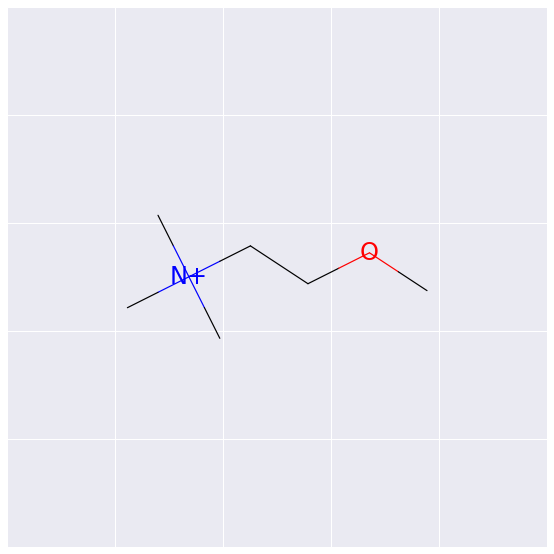

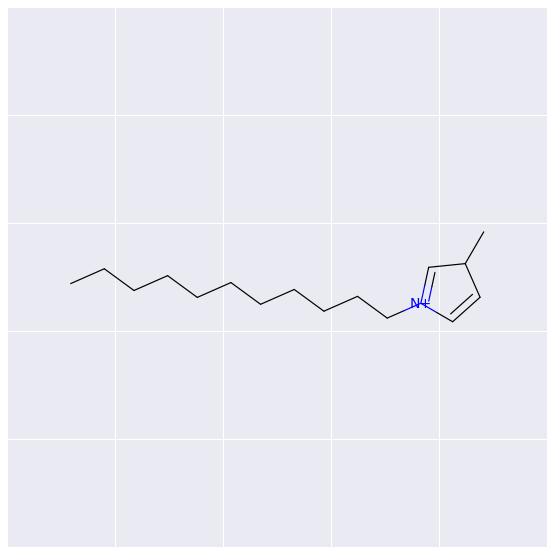

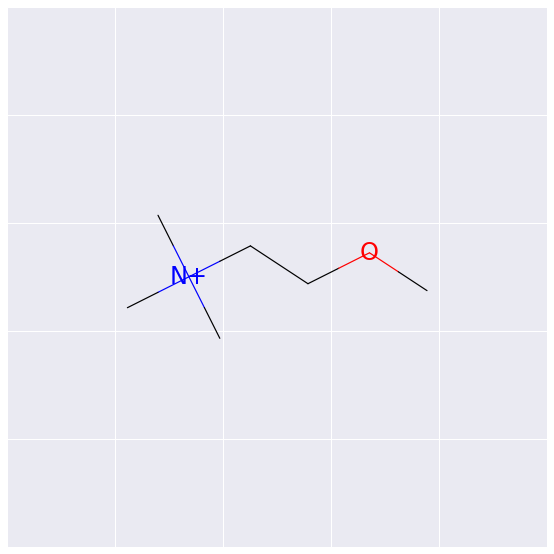

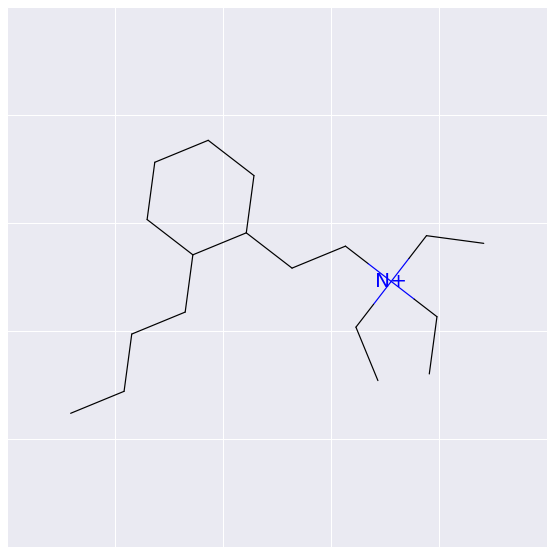

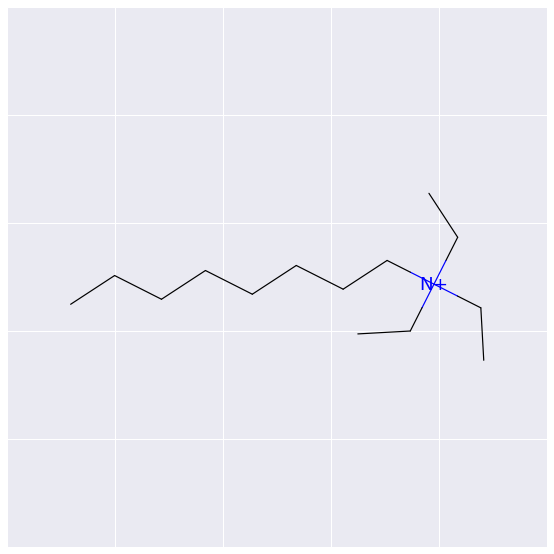

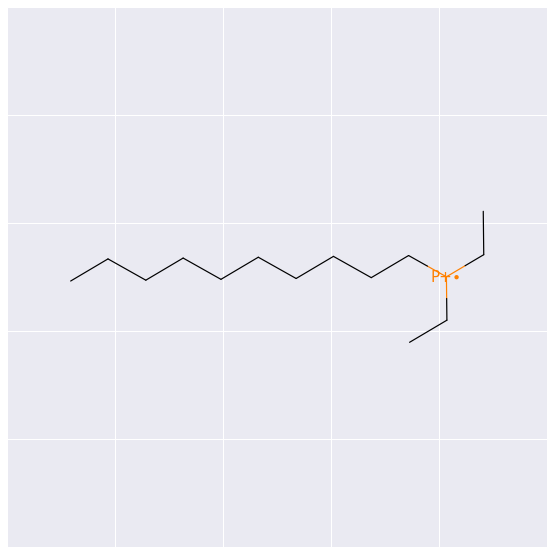

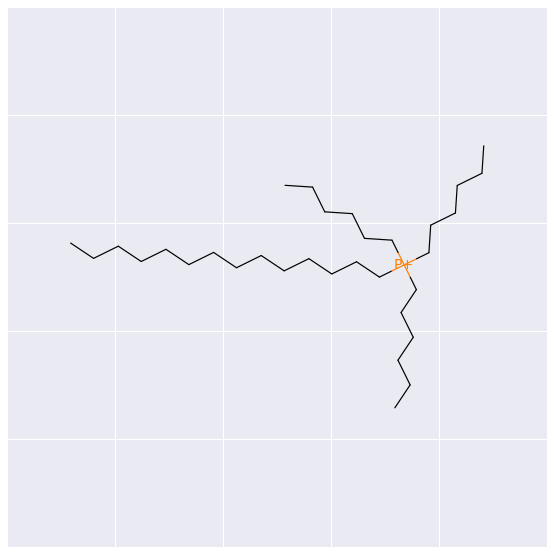

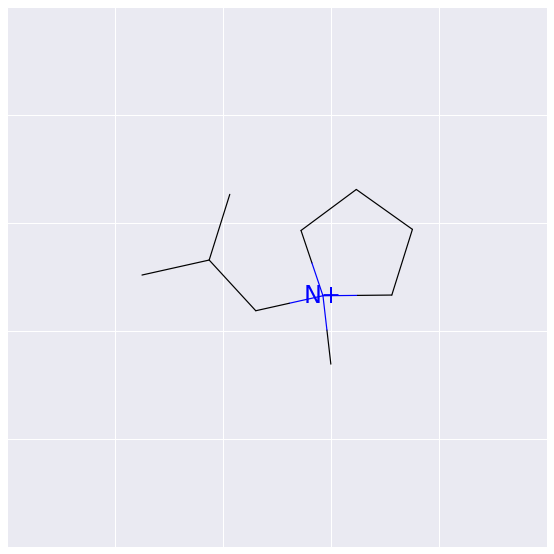

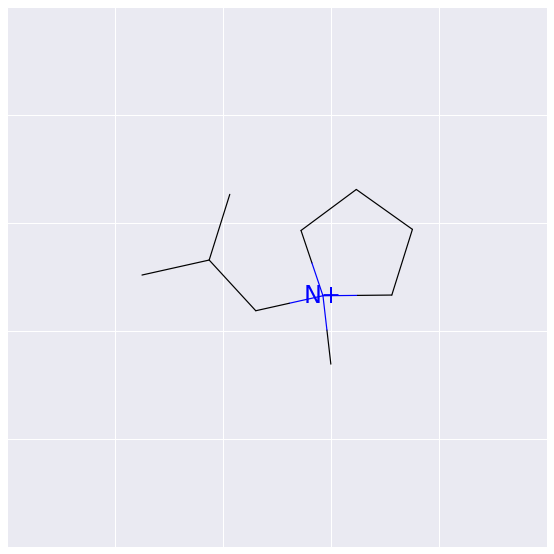

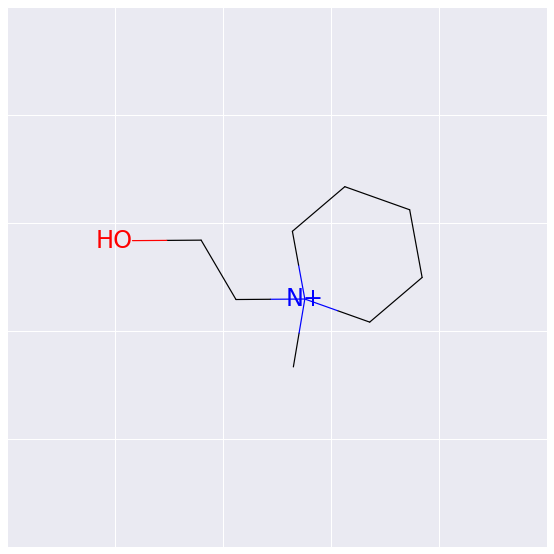

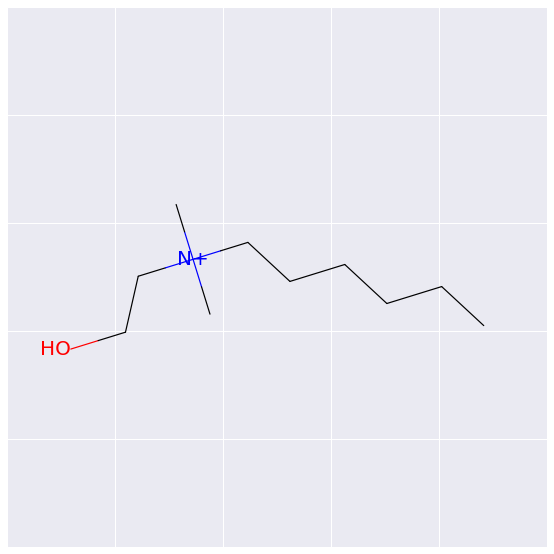

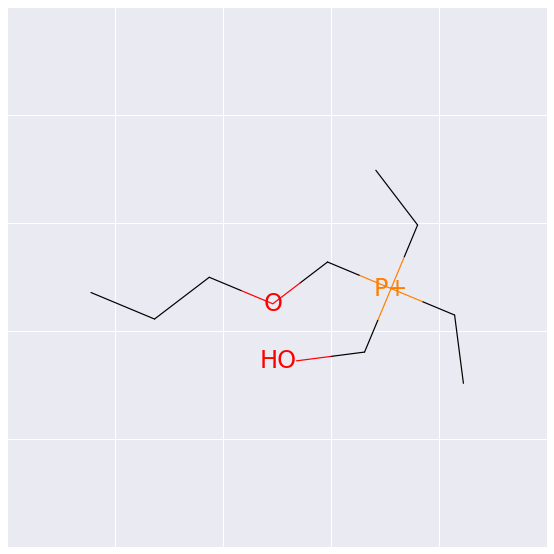

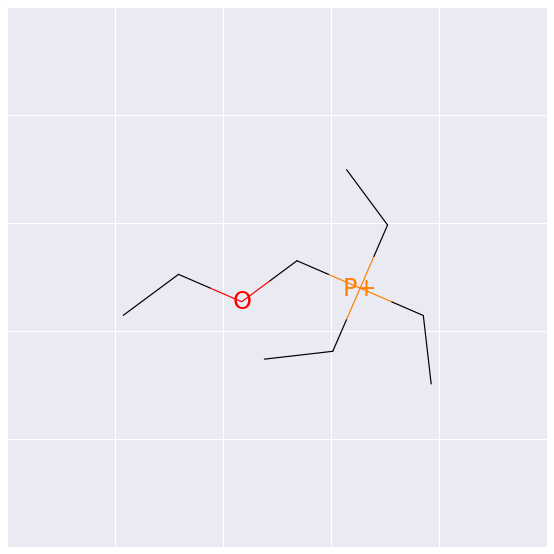

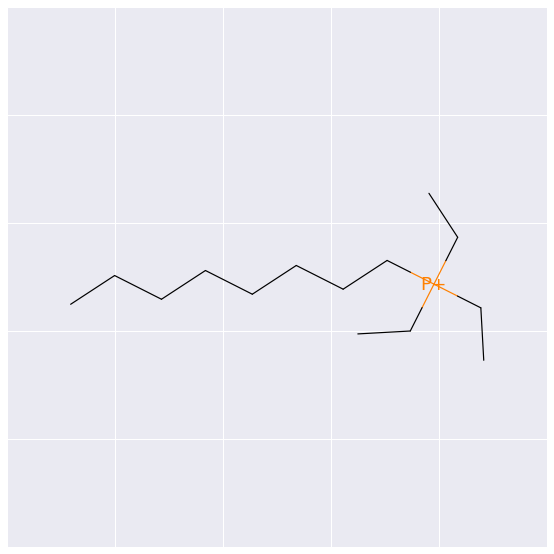

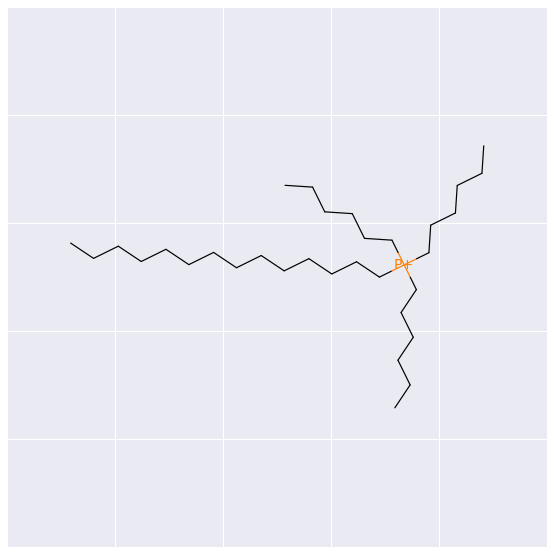

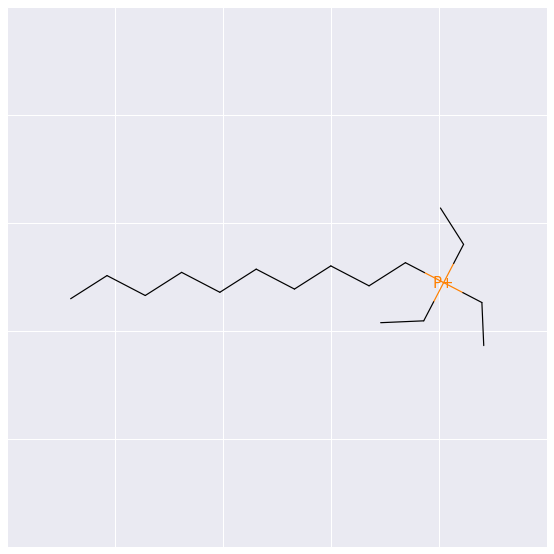

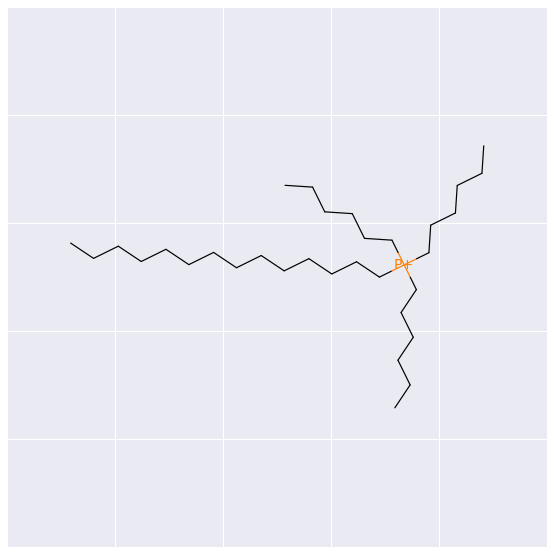

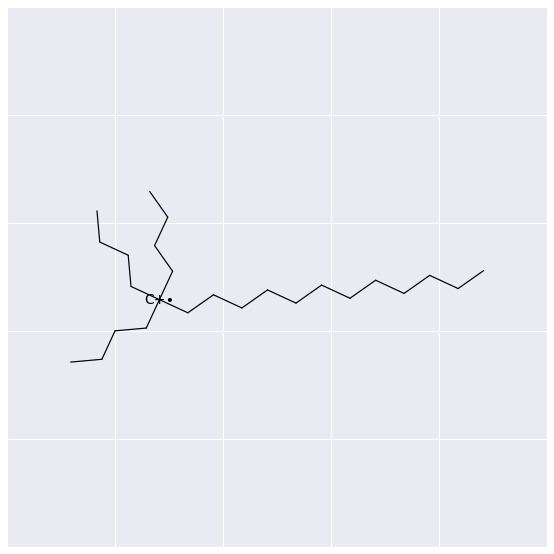

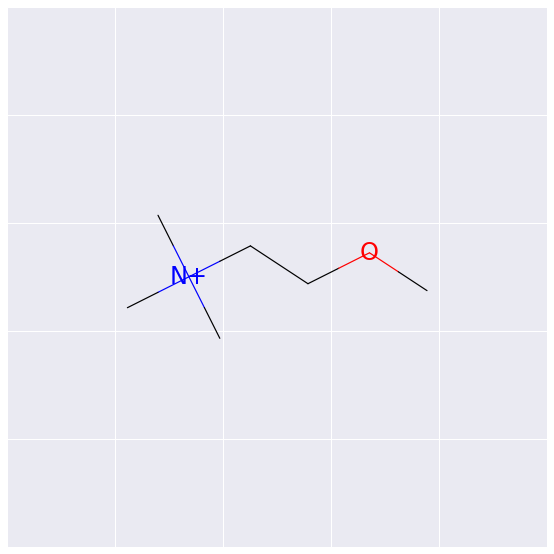

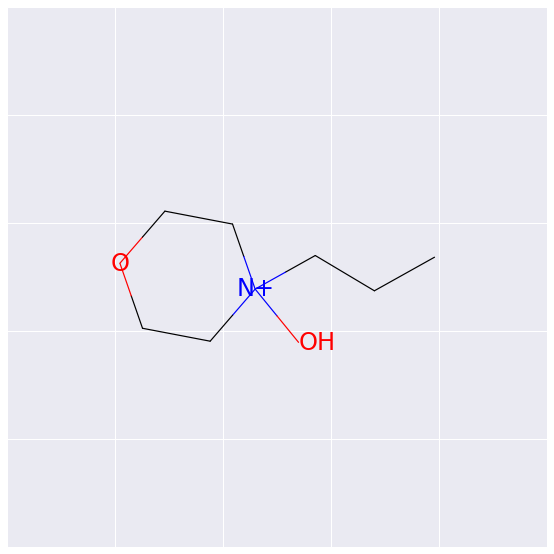

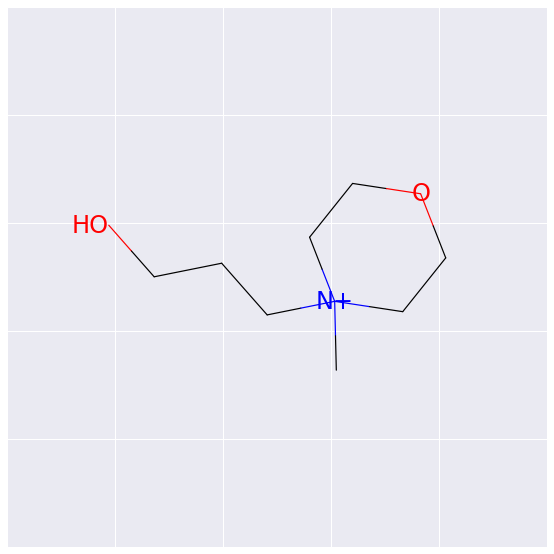

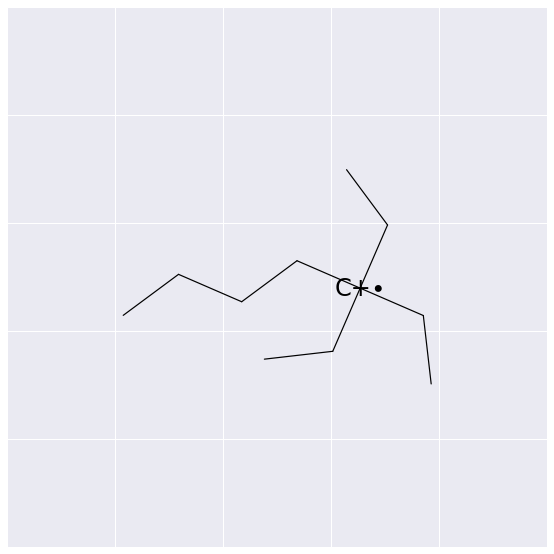

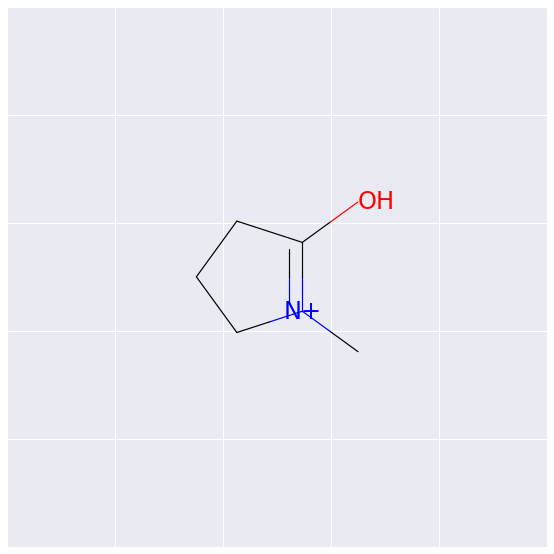

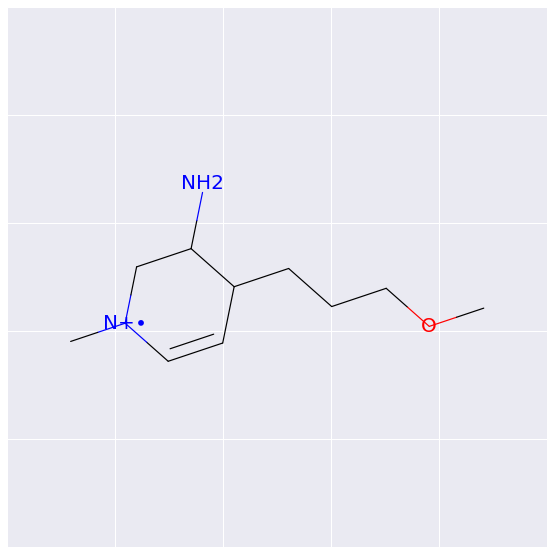

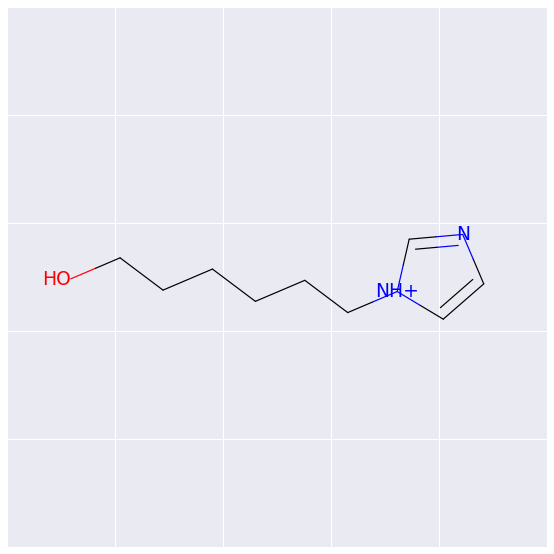

In [375]:
for item in rdkit_mols:
    vae_cat = Chem.MolFromSmiles(item)
    img = Draw.MolToMPL(vae_cat)
    score, index = get_sim(vae_cat)
    print(score)
    img2 = Draw.MolToMPL(Chem.MolFromSmiles(cations[index]))
#     if score < .9:
#         break

[N+](CCC(CC)(C)(CCC))C                             
CC[N+](CC)(CC)CCCCCCCC                             
CC1cC[n+](c1)CCCCCCCC                              
CCCCCCC(=C)CC1CCCCOOOC1            N               
C1=C[N+](CCC#C)=CN1CCCCCC                          
Cc1cc([n+](C1c2ccccc2)C)C                          
CCCCCC[C+](CCCCCO)(CCCCCC)CCCCCCC                  
C#CCCC1cc[C+](c1)CCN                               
CCCCCCC[n+]1cc[C](c1)CC                            
CCCCCCC[n+]1cc(C)ccc1                              
CCCCCC[n+]1cccc(C#N)c1                             
C1=C[N+](CCCC)=NN1C                                
CCNC[P+](CCCC)(CCCC)CCCC                           
CC1cc[C+](C1C)CCCCC                                
CCCCCCCCCCC[n+]1ccC(c1)C                           
CCCCC2CCCCC2CC[N+](CC)(CC)CC                       
[P+](CC)(CC)CCCC(CCCCCC)                           
C[N+]1(CCCC1)CC(C)(C)                              
C[N+]1(CCCCC1)CCO                                  
[P+](CC)(CO)

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


CC[C+](CC)(CC)CCCC                                 
C1=C[N+](C)CC(N)C1CCCOC                            


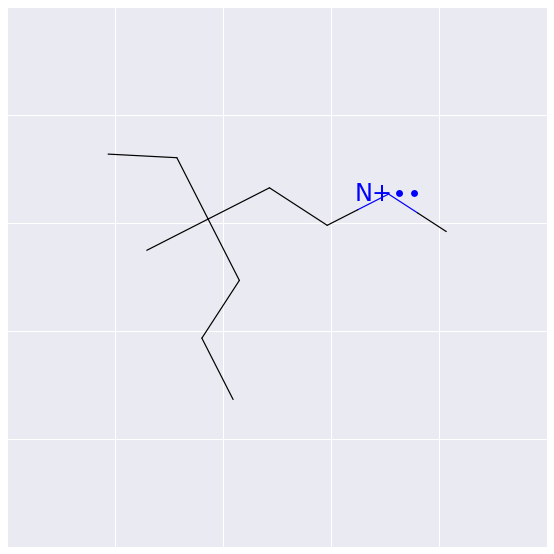

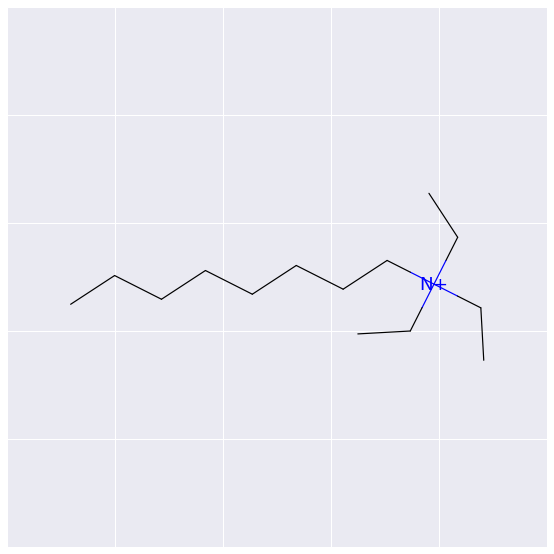

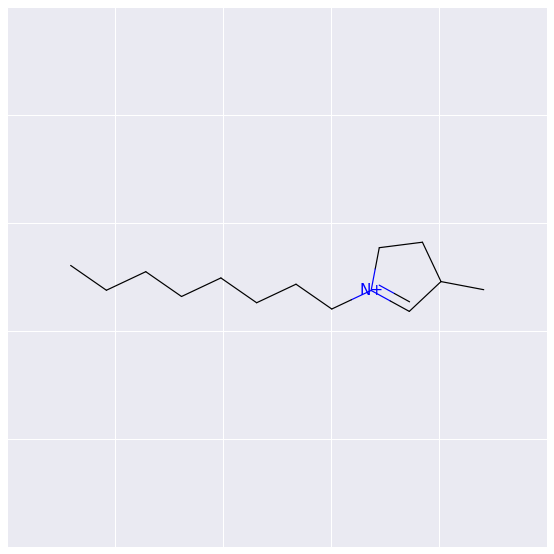

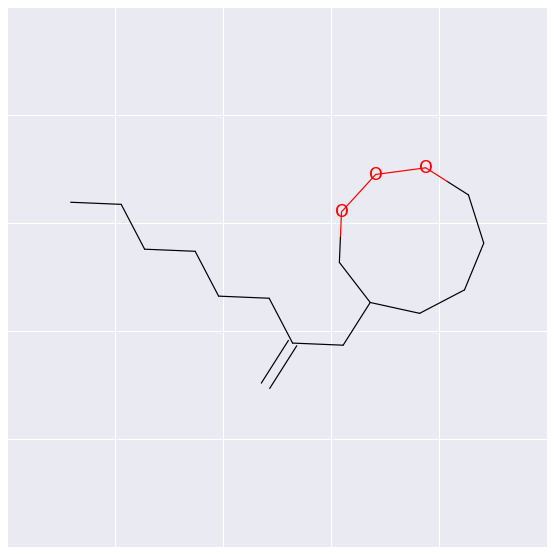

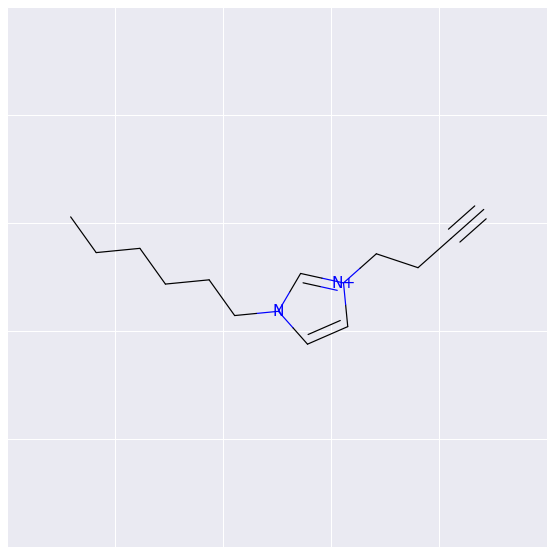

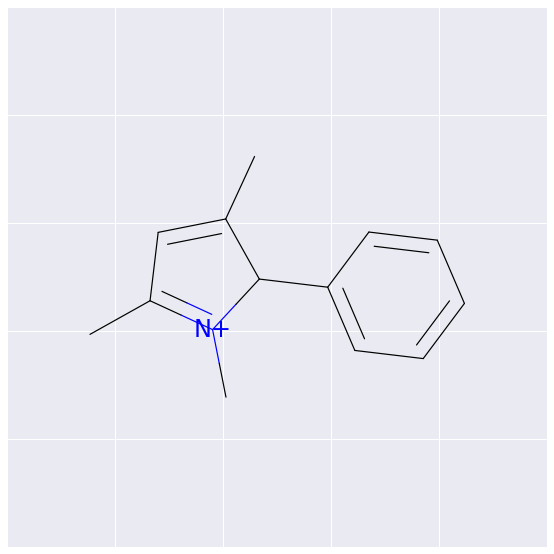

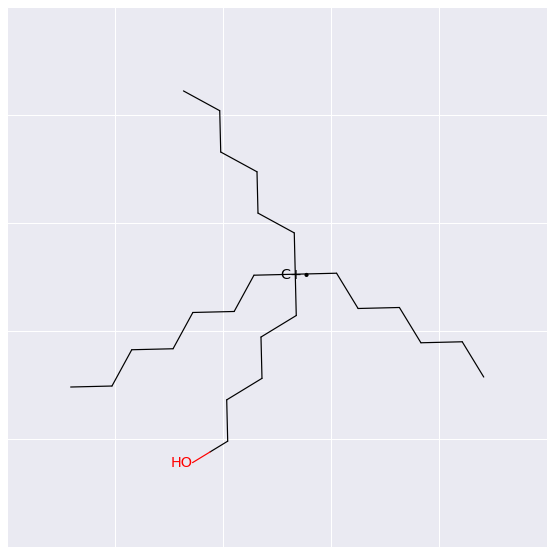

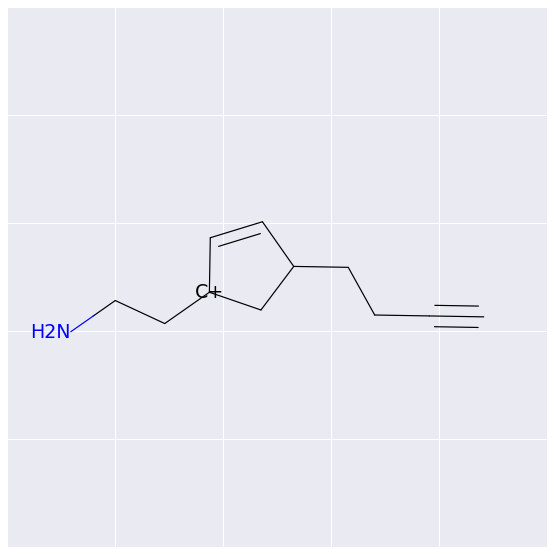

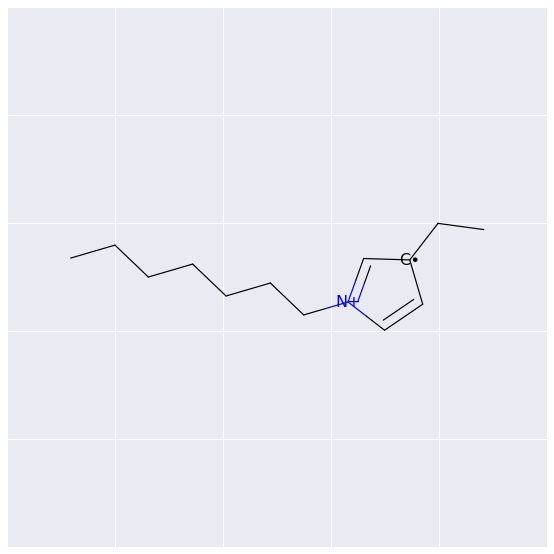

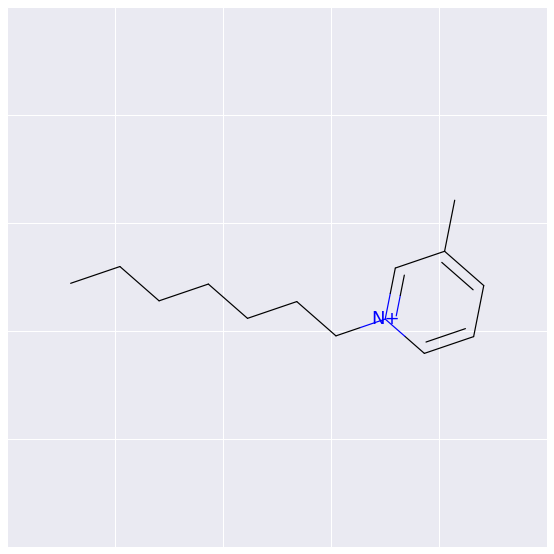

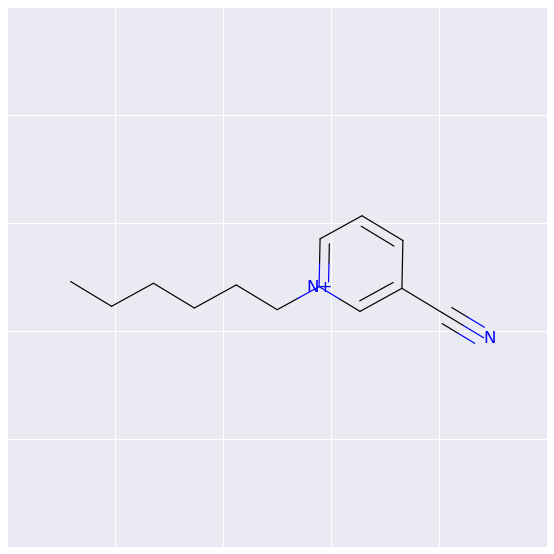

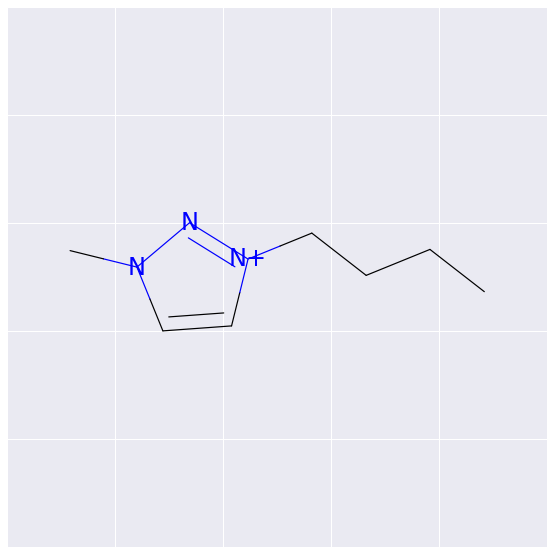

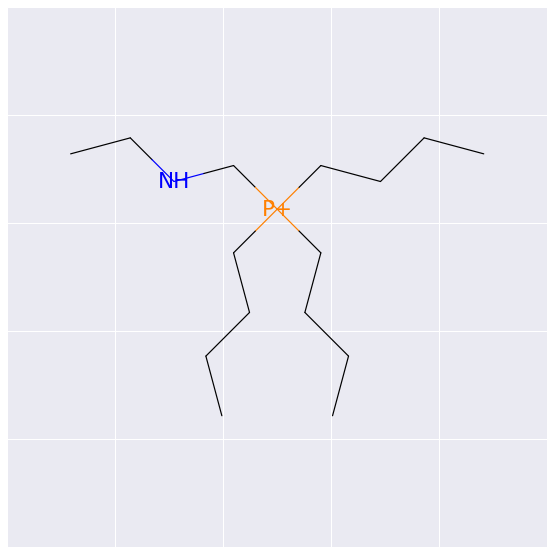

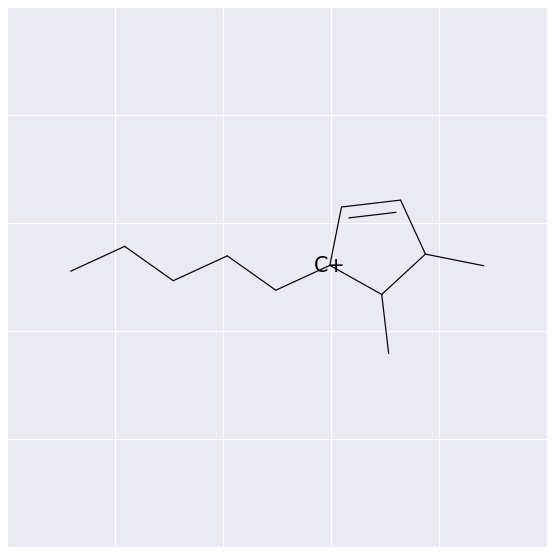

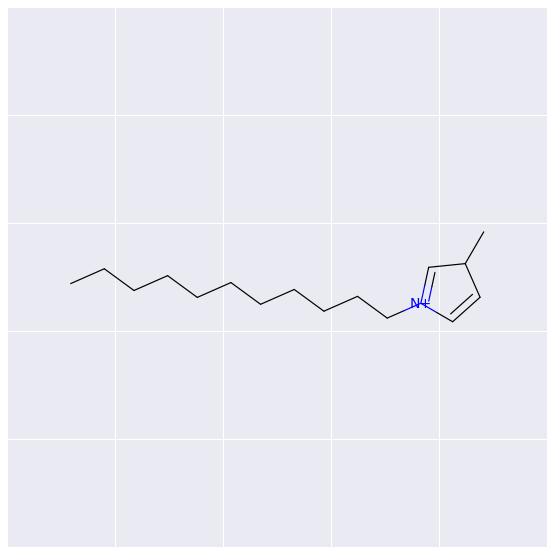

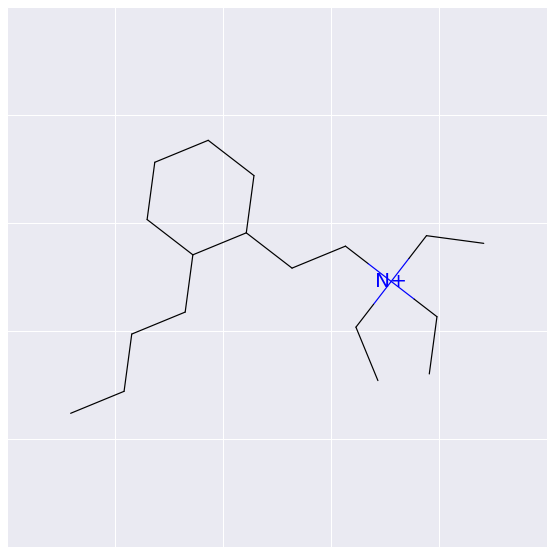

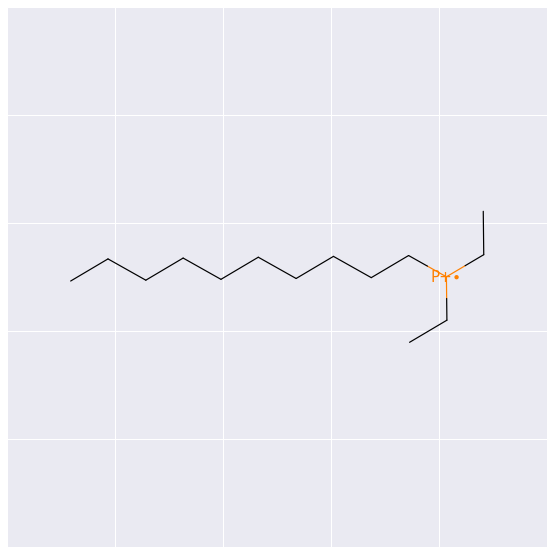

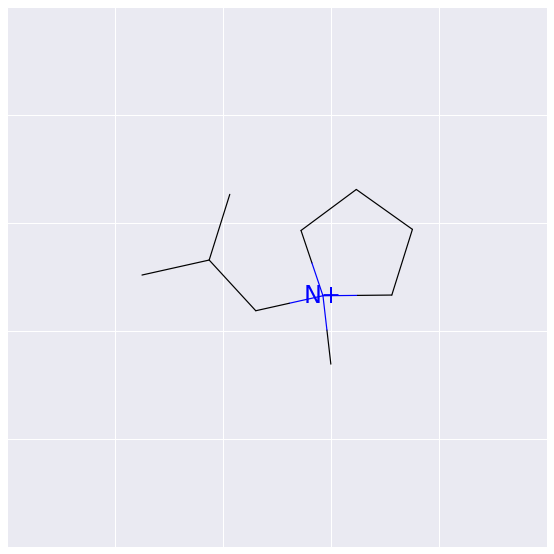

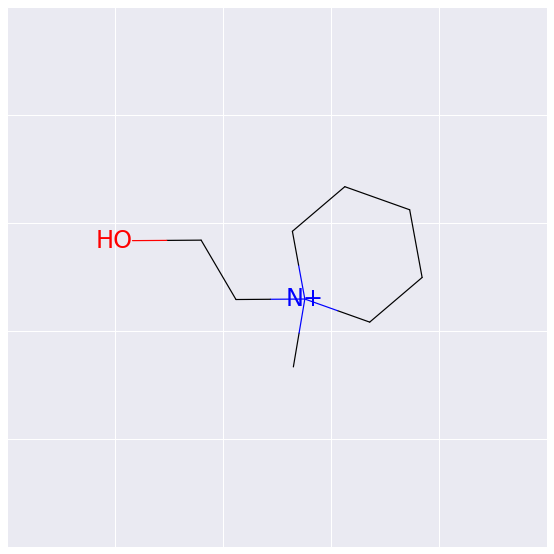

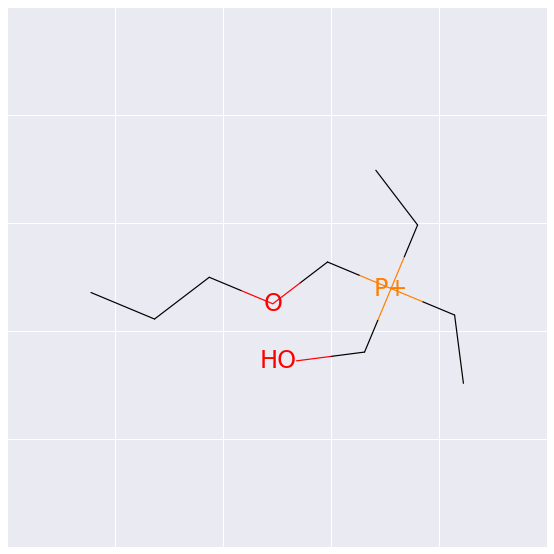

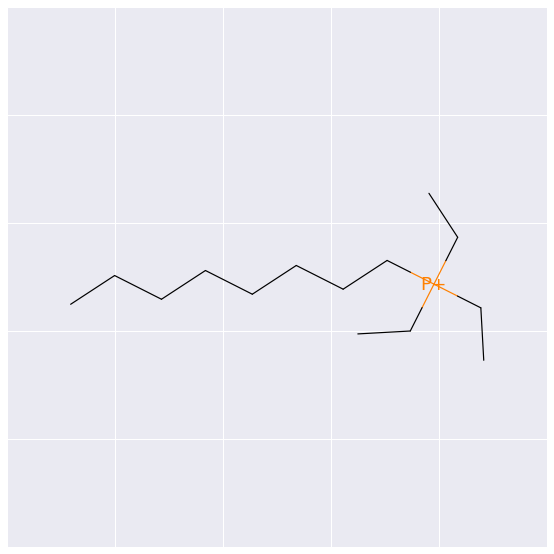

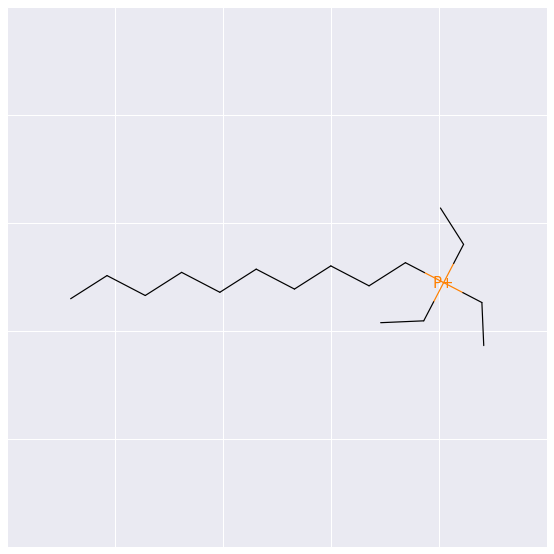

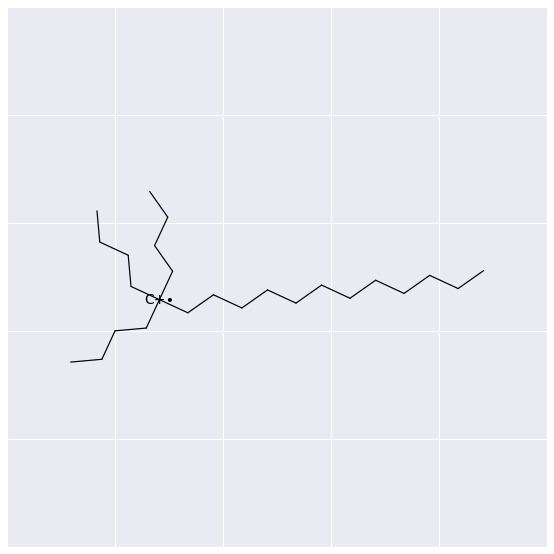

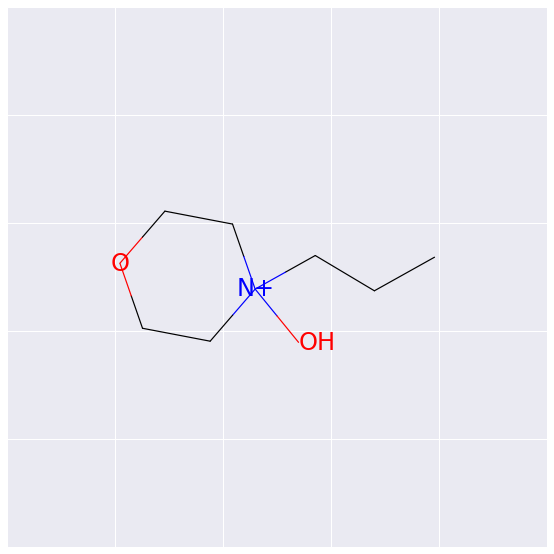

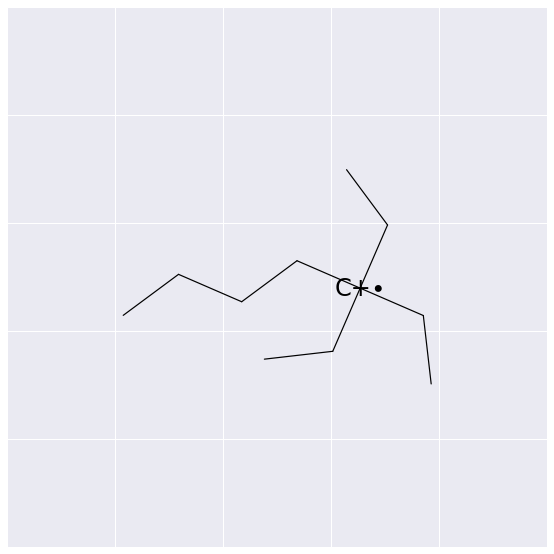

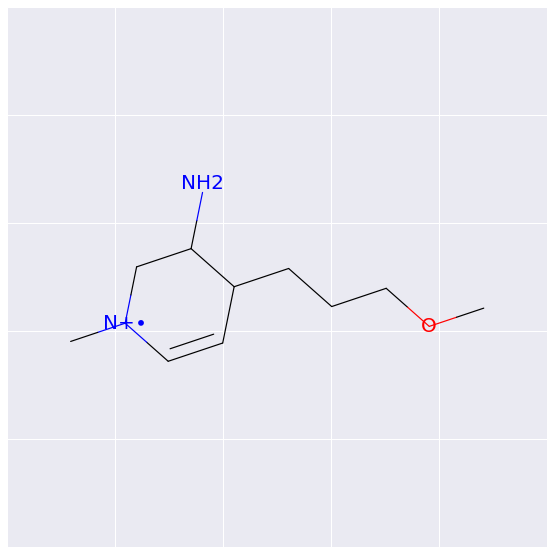

In [376]:
% matplotlib inline
rdkit_mols=[]
for smi in cation_samples:
    try:
        sampled = Chem.MolFromSmiles(smi)
        Draw.MolToMPL(sampled)
        rdkit_mols.append(smi)
        print(smi)
    except:
        pass